In [1]:
import logging
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from prophet import Prophet
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import yfinance

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled = True

Importing plotly failed. Interactive plots will not work.


# Model

In [2]:
def get_group_definition(X, pool_cols, pool_type):
    if pool_type == "complete":
        group = np.zeros(len(X), dtype="int")
        group_mapping = {0: "all"}
        n_groups = 1
    else:
        X[pool_cols] = pd.Categorical(X[pool_cols])
        group = X[pool_cols].cat.codes.values
        group_mapping = dict(enumerate(X[pool_cols].cat.categories))
        n_groups = X[pool_cols].nunique()
    return group, n_groups, group_mapping


class TimeSeriesModel:
    def _scale_data(self):
        self.y_min = 0
        self.y_max = self.data["y"].abs().max()
        self.ds_min = self.data["ds"].min()
        self.ds_max = self.data["ds"].max()

        self.data["y"] = self.data["y"] / self.y_max
        self.data["t"] = (self.data["ds"] - self.ds_min) / (self.ds_max - self.ds_min)

    def _process_data(self):
        self.data["ds"] = pd.to_datetime(self.data["ds"])
        self.data.sort_values("ds", inplace=True)
        self._scale_data()

    def _model_init(self):
        i0, i1 = self.data["ds"].idxmin(), self.data["ds"].idxmax()
        T = self.data["t"].iloc[i1] - self.data["t"].iloc[i0]
        slope = (self.data["y"].iloc[i1] - self.data["y"].iloc[i0]) / T
        intercept = self.data["y"].iloc[i0] - slope * self.data["t"].iloc[i0]
        return {
            "slope": slope,
            "intercept": intercept,
            "delta": 0.0,
            "beta": 0.0,
            "sigma": 1.0,
        }

    def fit(
        self,
        data,
        sigma_sd=0.5,
        mcmc_samples=0,
        chains=4,
        cores=4,
        use_prophet_initvals=True,
        progressbar=True,
    ):
        self.mcmc_samples = mcmc_samples

        self.data = data.reset_index(drop=True)
        self._process_data()

        self.initvals = {}
        # if use_prophet_initvals:
        #     self.initvals = self._model_init()

        self.model = pm.Model()
        self.model_idxs = {}
        mu = self.definition(self.model, self.data, self.initvals, self.model_idxs)

        with self.model:
            sigma = pm.HalfNormal(
                "sigma", sigma_sd, initval=self.initvals.get("sigma", 1)
            )
            _ = pm.Normal("obs", mu=mu, sigma=sigma, observed=self.data["y"])

            self.map_approx = None
            self.trace = None
            if self.mcmc_samples == 0:
                self.map_approx = pm.find_MAP(progressbar=progressbar, maxeval=1e4)
            else:
                self.trace = pm.sample(self.mcmc_samples, chains=chains, cores=cores)

    def _make_future_df(self, days):
        future = pd.DataFrame(
            {
                "ds": pd.DatetimeIndex(
                    np.hstack(
                        (
                            self.data["ds"].unique().to_numpy(),
                            pd.date_range(
                                self.ds_max,
                                self.ds_max + pd.Timedelta(days, "D"),
                                inclusive="right",
                            ).to_numpy(),
                        )
                    )
                )
            }
        )
        future["t"] = (future["ds"] - self.ds_min) / (self.ds_max - self.ds_min)
        return future

    def predict(self, days):
        future = self._make_future_df(days)
        forecasts = self._predict(
            future, self.mcmc_samples, self.map_approx, self.trace
        )

        for group_code in range(forecasts.shape[0]):
            future[f"yhat_{group_code}"] = forecasts[group_code] * self.y_max
            for model_type, model_cnt in self.model_idxs.items():
                if model_type.startswith("fs"):
                    continue
                for model_idx in range(model_cnt):
                    component = f"{model_type}_{model_idx}_{group_code}"
                    if component in future.columns:
                        future[component] *= self.y_max

        return future

    def _predict(self, future, mcmc_samples, map_approx, trace):
        if mcmc_samples == 0:
            return self._predict_map(future, map_approx)

        return self._predict_mcmc(future, trace)

    def plot(self, future, y_true=None, pool_cols=None):
        plt.figure(figsize=(14, 100 * 6))
        plt.subplot(100, 1, 1)
        plt.title("Predictions")
        plt.grid()

        group, _, groups_ = get_group_definition(self.data, pool_cols, "not_complete")
        for group_code, group_name in groups_.items():
            group_idx = group == group_code
            color = np.random.rand(3)
            plt.scatter(
                self.data["ds"][group_idx],
                self.data["y"][group_idx] * self.y_max,
                s=0.5,
                color=color,
                label=group_name,
            )

        if y_true is not None:
            test_group, _, test_groups_ = get_group_definition(
                y_true, pool_cols, "not_complete"
            )
            for group_code, group_name in test_groups_.items():
                group_idx = test_group == group_code
                color = np.random.rand(3)
                plt.scatter(
                    y_true["ds"][group_idx],
                    y_true["y"][group_idx],
                    s=0.5,
                    color=color,
                    label=f"y - {group_name}",
                )

        for group_code, group_name in groups_.items():
            plt.plot(
                future["ds"],
                future[f"yhat_{group_code}"],
                lw=1,
                label=f"yhat - {group_name}",
            )

        plt.legend()
        plot_params = {"idx": 1}
        self._plot(plot_params, future, self.data, self.y_max, y_true)

    def metrics(self, y_true, future, pool_cols=None, pool_type="individual"):
        metrics = {"mse": {}, "rmse": {}, "mae": {}, "mape": {}}
        test_group, _, test_groups_ = get_group_definition(y_true, pool_cols, pool_type)
        for group_code, group_name in test_groups_.items():
            group_idx = test_group == group_code
            y = y_true["y"][group_idx]
            yhat = future[f"yhat_{group_code}"][-len(y) :]
            metrics["mse"][group_name] = mean_squared_error(y, yhat)
            metrics["rmse"][group_name] = root_mean_squared_error(y, yhat)
            metrics["mae"][group_name] = mean_absolute_error(y, yhat)
            metrics["mape"][group_name] = mean_absolute_percentage_error(y, yhat)

        return pd.DataFrame(metrics)

    def __add__(self, other):
        return AdditiveTimeSeries(self, other)

    def __mul__(self, other):
        return MultiplicativeTimeSeries(self, other)


class AdditiveTimeSeries(TimeSeriesModel):
    def __init__(self, left, right):
        self.left = left
        self.right = right

    def definition(self, *args, **kwargs):
        return self.left.definition(*args, **kwargs) + self.right.definition(
            *args, **kwargs
        )

    def _predict(self, *args, **kwargs):
        return self.left._predict(*args, **kwargs) + self.right._predict(
            *args, **kwargs
        )

    def _plot(self, *args, **kwargs):
        self.left._plot(*args, **kwargs)
        self.right._plot(*args, **kwargs)


class MultiplicativeTimeSeries(TimeSeriesModel):
    def __init__(self, left, right):
        self.left = left
        self.right = right

    def definition(self, *args, **kwargs):
        return self.left.definition(*args, **kwargs) * (
            1 + self.right.definition(*args, **kwargs)
        )

    def _predict(self, *args, **kwargs):
        return self.left._predict(*args, **kwargs) * (
            1 + self.right._predict(*args, **kwargs)
        )

    def _plot(self, *args, **kwargs):
        self.left._plot(*args, **kwargs)
        self.right._plot(*args, **kwargs)


class LinearTrend(TimeSeriesModel):
    def __init__(
        self,
        n_changepoints=25,
        changepoint_range=0.8,
        slope_mean=0,
        slope_sd=5,
        intercept_mean=0,
        intercept_sd=5,
        delta_mean=0,
        delta_sd=0.05,
        pool_cols=None,
        pool_type="complete",
    ):
        self.n_changepoints = n_changepoints
        self.changepoint_range = changepoint_range
        self.slope_mean = slope_mean
        self.slope_sd = slope_sd
        self.intercept_mean = intercept_mean
        self.intercept_sd = intercept_sd
        self.delta_mean = delta_mean
        self.delta_sd = delta_sd

        self.pool_cols = pool_cols
        self.pool_type = pool_type

    def definition(self, model, data, initvals, model_idxs):
        model_idxs["lt"] = model_idxs.get("lt", 0)
        self.model_idx = model_idxs["lt"]
        model_idxs["lt"] += 1

        self.group, self.n_groups, self.groups_ = get_group_definition(
            data, self.pool_cols, self.pool_type
        )

        with model:
            if self.pool_type == "partial":
                sigma_slope = pm.HalfCauchy(
                    f"lt_{self.model_idx} - sigma_slope", beta=self.slope_sd
                )
                offset_slope = pm.Normal(
                    f"lt_{self.model_idx} - offset_slope",
                    mu=0,
                    sigma=1,
                    shape=self.n_groups,
                )
                slope = pm.Deterministic(
                    f"lt_{self.model_idx} - slope", offset_slope * sigma_slope
                )

                delta_sd = self.delta_sd
                if self.delta_sd is None:
                    delta_sd = pm.Exponential(f"lt_{self.model_idx} - tau", 1.5)

                sigma_delta = pm.HalfCauchy(
                    f"lt_{self.model_idx} - sigma_delta", beta=delta_sd
                )
                offset_delta = pm.Laplace(
                    f"lt_{self.model_idx} - offset_delta",
                    0,
                    1,
                    shape=(self.n_groups, self.n_changepoints),
                )
                delta = pm.Deterministic(
                    f"lt_{self.model_idx} - delta", offset_delta * sigma_delta
                )
            else:
                slope = pm.Normal(
                    f"lt_{self.model_idx} - slope",
                    self.slope_mean,
                    self.slope_sd,
                    initval=initvals.get("slope", None),
                    shape=self.n_groups,
                )

                delta_sd = self.delta_sd
                if self.delta_sd is None:
                    delta_sd = pm.Exponential(f"lt_{self.model_idx} - tau", 1.5)

                delta = pm.Laplace(
                    f"lt_{self.model_idx} - delta",
                    self.delta_mean,
                    delta_sd,
                    shape=(self.n_groups, self.n_changepoints),
                )

            intercept = pm.Normal(
                f"lt_{self.model_idx} - intercept",
                self.intercept_mean,
                self.intercept_sd,
                initval=initvals.get("intercept", None),
                shape=self.n_groups,
            )

            if self.pool_type == "individual":
                ss = []
                t = np.array(data["t"])
                for group_code in range(self.n_groups):
                    series_data = data[self.group == group_code]
                    hist_size = int(
                        np.floor(series_data.shape[0] * self.changepoint_range)
                    )
                    cp_indexes = (
                        np.linspace(0, hist_size - 1, self.n_changepoints + 1)
                        .round()
                        .astype(int)
                    )
                    ss.append(np.array(series_data.iloc[cp_indexes]["t"].tail(-1)))

                self.s = np.stack(ss, axis=0)
                A = (t[:, None] > self.s[self.group]) * 1

                gamma = -self.s[self.group, :] * delta[self.group, :]
                trend = pm.Deterministic(
                    f"lt_{self.model_idx} - trend",
                    (slope[self.group] + pm.math.sum(A * delta[self.group], axis=1)) * t
                    + (intercept[self.group] + pm.math.sum(A * gamma, axis=1)),
                )
            else:
                t = np.array(data["t"])
                hist_size = int(np.floor(data.shape[0] * self.changepoint_range))
                cp_indexes = (
                    np.linspace(0, hist_size - 1, self.n_changepoints + 1)
                    .round()
                    .astype(int)
                )
                self.s = np.array(data.iloc[cp_indexes]["t"].tail(-1))
                A = (t[:, None] > self.s) * 1

                gamma = -self.s * delta[self.group, :]
                trend = pm.Deterministic(
                    f"lt_{self.model_idx} - trend",
                    (slope[self.group] + pm.math.sum(A * delta[self.group], axis=1)) * t
                    + (intercept[self.group] + pm.math.sum(A * gamma, axis=1)),
                )

        return trend

    def _predict_map(self, future, map_approx):
        forecasts = []
        if self.pool_type != "individual":
            new_A = (np.array(future["t"])[:, None] > self.s) * 1

        for group_code in self.groups_.keys():
            if self.pool_type == "individual":
                s = self.s[group_code]
                new_A = (np.array(future["t"])[:, None] > self.s[group_code]) * 1
            else:
                s = self.s

            forecasts.append(
                np.array(
                    (
                        map_approx[f"lt_{self.model_idx} - slope"][group_code]
                        + np.dot(
                            new_A,
                            map_approx[f"lt_{self.model_idx} - delta"][group_code],
                        )
                    )
                    * future["t"]
                    + (
                        map_approx[f"lt_{self.model_idx} - intercept"][group_code]
                        + np.dot(
                            new_A,
                            (
                                -s
                                * map_approx[f"lt_{self.model_idx} - delta"][group_code]
                            ),
                        )
                    )
                )
            )
            future[f"lt_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _predict_mcmc(self, future, trace):
        forecasts = []
        if self.pool_type == "individual":
            new_A = (np.array(future["t"])[:, None] > self.s[self.group]) * 1
        else:
            new_A = (np.array(future["t"])[:, None] > self.s) * 1

        for group_code in self.groups_.keys():
            delta = (
                trace["posterior"][f"lt_{self.model_idx} - delta"]
                .to_numpy()[:, :, group_code]
                .mean(0)
            )
            slope = (
                trace["posterior"][f"lt_{self.model_idx} - slope"]
                .to_numpy()[:, :, group_code]
                .mean(0)
            )
            intercept = (
                trace["posterior"][f"lt_{self.model_idx} - intercept"]
                .to_numpy()[:, :, group_code]
                .mean(0)
            )

            forecasts.append(
                (
                    (slope + np.dot(new_A, delta.T)).T * future["t"].to_numpy()
                    + (intercept + np.dot(new_A, (-self.s * delta).T)).T
                ).mean(0)
            )
            future[f"lt_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _plot(self, plot_params, future, data, y_max, y_true=None):
        plot_params["idx"] += 1
        plt.subplot(100, 1, plot_params["idx"])
        plt.title(f"lt_{self.model_idx}")
        plt.grid()

        for group_code, group_name in self.groups_.items():
            plt.plot(
                future["ds"],
                future[f"lt_{self.model_idx}_{group_code}"],
                lw=1,
                label=group_name,
            )

        plt.legend()


class FourierSeasonality(TimeSeriesModel):
    def __init__(
        self,
        period,
        series_order,
        beta_mean=0,
        beta_sd=10,
        shrinkage_strength=100,
        pool_cols=None,
        pool_type="complete",
    ):
        self.period = period
        self.series_order = series_order
        self.beta_mean = beta_mean
        self.beta_sd = beta_sd
        self.shrinkage_strength = shrinkage_strength

        self.pool_cols = pool_cols
        self.pool_type = pool_type

    def _fourier_series(self, data):
        # convert to days since epoch
        NANOSECONDS_TO_SECONDS = 1000 * 1000 * 1000
        t = (
            data["ds"].to_numpy(dtype=np.int64)
            // NANOSECONDS_TO_SECONDS
            / (3600 * 24.0)
        )

        x_T = t * np.pi * 2
        fourier_components = np.empty((data["ds"].shape[0], 2 * self.series_order))
        for i in range(self.series_order):
            c = x_T * (i + 1) / self.period
            fourier_components[:, 2 * i] = np.sin(c)
            fourier_components[:, (2 * i) + 1] = np.cos(c)

        return fourier_components

    def definition(self, model, data, initvals, model_idxs):
        model_idxs["fs"] = model_idxs.get("fs", 0)
        self.model_idx = model_idxs["fs"]
        model_idxs["fs"] += 1

        group, n_groups, self.groups_ = get_group_definition(
            data, self.pool_cols, self.pool_type
        )

        x = self._fourier_series(data)
        beta_initval = initvals.get("beta", None)
        if beta_initval is not None:
            beta_initval = np.array([beta_initval] * 2 * self.series_order)

        with model:
            if self.pool_type == "partial":
                # shift_t = pm.Uniform(
                #     f"fs_{self.model_idx} - shift_t(p={self.period},n={self.series_order})",
                #     lower=0,
                #     upper=self.period,
                #     shape=n_groups,
                # )
                mu_beta = pm.Normal(
                    f"fs_{self.model_idx} - beta_mu(p={self.period},n={self.series_order})",
                    mu=self.beta_mean,
                    sigma=self.beta_sd,
                    shape=2 * self.series_order,
                    initval=beta_initval,
                )
                sigma_beta = pm.HalfNormal(
                    f"fs_{self.model_idx} - beta_sigma(p={self.period},n={self.series_order})",
                    sigma=self.beta_sd / self.shrinkage_strength,
                    shape=2 * self.series_order,
                )
                offset_beta = pm.Normal(
                    f"fs_{self.model_idx} - offset_beta(p={self.period},n={self.series_order})",
                    mu=0,
                    sigma=1,
                    shape=(n_groups, 2 * self.series_order),
                )

                beta = pm.Deterministic(
                    f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})",
                    mu_beta + offset_beta * sigma_beta,
                )
            else:
                beta = pm.Normal(
                    f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})",
                    mu=self.beta_mean,
                    sigma=self.beta_sd,
                    shape=(n_groups, 2 * self.series_order),
                    initval=beta_initval,
                )

        return pm.math.sum(x * beta[group], axis=1)

    def _det_seasonality_posterior(self, beta, x):
        return np.dot(x, beta.T)

    def _predict_map(self, future, map_approx):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                self._det_seasonality_posterior(
                    map_approx[
                        f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})"
                    ][group_code],
                    self._fourier_series(future),
                )
            )
            future[f"fs_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _predict_mcmc(self, future, trace):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                self._det_seasonality_posterior(
                    trace["posterior"][
                        f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})"
                    ]
                    .to_numpy()[:, :, group_code]
                    .mean(0),
                    self._fourier_series(future),
                ).T.mean(0)
            )
            future[f"fs_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _plot(self, plot_params, future, data, y_max, y_true=None):
        date = future["ds"] if self.period > 7 else future["ds"].dt.day_name()
        plot_params["idx"] += 1
        plt.subplot(100, 1, plot_params["idx"])
        plt.title(f"fs_{self.model_idx} - p={self.period},n={self.series_order}")
        plt.grid()

        for group_code, group_name in self.groups_.items():
            plt.plot(
                date[-int(self.period) :],
                future[f"fs_{self.model_idx}_{group_code}"][-int(self.period) :],
                lw=1,
                label=group_name,
            )

        plt.legend()


class Constant(TimeSeriesModel):
    def __init__(self, lower, upper, pool_cols=None, pool_type="complete"):
        self.lower = lower
        self.upper = upper
        self.pool_cols = pool_cols
        self.pool_type = pool_type

    def definition(self, model, data, initvals, model_idxs):
        model_idxs["c"] = model_idxs.get("c", 0)
        self.model_idx = model_idxs["c"]
        model_idxs["c"] += 1

        group, n_groups, self.groups_ = get_group_definition(
            data, self.pool_cols, self.pool_type
        )

        with model:
            if self.pool_type == "partial":
                mu_c = pm.Uniform(
                    f"c_{self.model_idx} - mu_c(l={self.lower},u={self.upper})",
                    lower=self.lower,
                    upper=self.upper,
                    shape=n_groups,
                )
                offset_c = pm.Normal(
                    f"c_{self.model_idx} - offset_c(l={self.lower},u={self.upper})",
                    mu=0,
                    sigma=1,
                    shape=n_groups,
                )
                c = pm.Deterministic(
                    f"c_{self.model_idx} - c(l={self.lower},u={self.upper})",
                    mu_c + offset_c,
                )
            else:
                c = pm.Uniform(
                    f"c_{self.model_idx} - c(l={self.lower},u={self.upper})",
                    lower=self.lower,
                    upper=self.upper,
                    shape=n_groups,
                )

        return c[group]

    def _predict_map(self, future, map_approx):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                np.ones_like(future["t"])
                * map_approx[f"c_{self.model_idx} - c(l={self.lower},u={self.upper})"][
                    group_code
                ]
            )
            future[f"c_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _predict_mcmc(self, future, trace):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                np.ones_like(future["t"])
                * trace["posterior"][
                    f"c_{self.model_idx} - c(l={self.lower},u={self.upper})"
                ]
                .to_numpy()[:, :, group_code]
                .mean()
            )
            future[f"c_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _plot(self, plot_params, future, data, y_max, y_true=None):
        plot_params["idx"] += 1
        plt.subplot(100, 1, plot_params["idx"])
        plt.title(f"c_{self.model_idx} - c(l={self.lower},u={self.upper})")

        plot_data = []
        for group_code, group_name in self.groups_.items():
            plot_data.append(
                (group_name, future[f"c_{self.model_idx}_{group_code}"][0])
            )

        plt.bar(*zip(*plot_data))
        plt.axhline(0, c="k", linewidth=3)

# Fetch data

In [3]:
# indexes = ["^W5000", "^GSPC", "^IXIC", "^DJI"]
indexes = ["^GSPC"]

gspc_tickers = [
    "AAPL", "MSFT", "AMZN", "FB", "TSLA", "GOOGL", "GOOG", "JNJ", "JPM", "V",
    "PG", "UNH", "DIS", "NVDA", "MA", "HD", "PYPL", "VZ", "ADBE", "CMCSA",
    "NFLX", "BAC", "KO", "MRK", "PEP", "T", "PFE", "INTC", "CRM", "WMT", "ABT",
    "ABBV", "CSCO", "TMO", "NKE", "AVGO", "XOM", "QCOM", "COST", "ACN", "CVX",
    "MCD", "MDT", "NEE", "TXN", "HON", "DHR", "UNP", "BMY", "LIN", "LLY",
    "AMGN", "PM", "C", "SBUX", "WFC", "ORCL", "UPS", "LOW", "BA", "IBM", "AMD",
    "RTX", "NOW", "BLK", "MMM", "INTU", "AMT", "CAT", "MS", "CHTR", "ISRG",
    "GE", "BKNG", "GS", "CVS", "TGT", "FIS", "LMT", "DE", "MU", "MDLZ", "TJX",
    "SYK", "ANTM", "SCHW", "SPGI", "AXP", "AMAT", "TMUS", "ZTS", "MO", "ADP",
    "CI", "PLD", "CL", "GILD", "BDX", "ATVI", "CB", "CSX", "CCI", "LRCX",
    "DUK", "ADSK", "FISV", "CME", "SO", "ICE", "TFC", "GPN", "USB", "EQIX",
    "PNC", "FDX", "VRTX", "D", "APD", "NSC", "EL", "SHW", "MMC", "ITW", "PGR",
    "EW", "ADI", "HUM", "ILMN", "ECL", "GM", "DD", "DG", "BSX", "REGN", "AON",
    "NEM", "EMR", "ETN", "NOC", "MCO", "KMB", "WM", "COF", "ROP", "CTSH",
    "ROST", "HCA", "TWTR", "COP", "IDXX", "EA", "AEP", "EXC", "DOW", "BAX",
    "TEL", "KLAC", "LHX", "SNPS", "APH", "DLR", "CMG", "ALGN", "CDNS", "SYY",
    "FCX", "BIIB", "STZ", "MSCI", "SRE", "A", "MCHP", "GIS", "MET", "TRV",
    "DXCM", "APTV", "PSA", "PH", "MAR", "XEL", "TT", "CNC", "XLNX", "GD", "BK",
    "F", "IQV", "TROW", "ALXN", "MNST", "PPG", "HPQ", "VRSK", "JCI", "TDG",
    "CMI", "INFO", "ALL", "EBAY", "ORLY", "YUM", "AIG", "ZBH", "SBAC", "ANSS",
    "CTAS", "PRU", "HLT", "RMD", "CARR", "PSX", "BLL", "SLB", "PCAR", "PAYX",
    "ES", "PEG", "ROK", "EOG", "AFL", "WEC", "CTVA", "MSI", "WBA", "SWK",
    "ADM", "FAST", "SPG", "MCK", "AME", "AWK", "DFS", "LUV", "OTIS", "GLW",
    "AZO", "VFC", "WLTW", "MTD", "WELL", "MPC", "KMI", "CPRT", "STT", "DAL",
    "FRC", "CLX", "DLTR", "SWKS", "WY", "ED", "KR", "KEYS", "WMB", "CERN",
    "TTWO", "FTV", "AJG", "EIX", "MKC", "MXIM", "LYB", "DTE", "EFX", "VLO",
    "BBY", "AMP", "DHI", "FLT", "VTRS", "HSY", "KHC", "AVB", "PAYC", "ETSY",
    "O", "VRSN", "PPL", "CHD", "MKTX", "ARE", "VIAC", "CBRE", "LEN", "WST",
    "ZBRA", "EQR", "RSG", "SIVB", "FTNT", "ETR", "TER", "LH", "VMC", "FITB",
    "LVS", "IP", "NTRS", "AEE", "TFX", "KSU", "QRVO", "TSN", "SYF", "CDW",
    "ODFL", "PXD", "HOLX", "AMCR", "GWW", "VTR", "XYL", "DOV", "EXPE", "GRMN",
    "COO", "CAG", "BR", "MLM", "TYL", "HIG", "CMS", "CTLT", "AKAM", "OKE",
    "IR", "WDC", "URI", "HAL", "FE", "TSCO", "MTB", "PEAK", "INCY", "ULTA",
    "STE", "CCL", "EXPD", "PKI", "NUE", "DGX", "KEY", "CTXS", "VAR", "K",
    "ANET", "CAH", "ALB", "AES", "DRI", "KMX", "RF", "ESS", "WAT", "CFG",
    "HPE", "NDAQ", "CE", "DPZ", "IEX", "EXR", "POOL", "FMC", "DRE", "NTAP",
    "ABMD", "OXY", "MAA", "GPC", "TDY", "HES", "ABC", "MAS", "IT", "NVR",
    "TIF", "J", "LDOS", "BKR", "STX", "RCL", "EMN", "OMC", "BXP", "SJM", "WAB",
    "HRL", "PKG", "CINF", "AVY", "MGM", "LNT", "HBAN", "CHRW", "PFG", "UAL",
    "EVRG", "BIO", "JKHY", "NLOK", "HAS", "ATO", "FBHS", "CNP", "RJF", "IFF",
    "PHM", "LW", "CXO", "XRAY", "WRK", "JBHT", "UDR", "WHR", "HWM", "TXT",
    "WYNN", "FFIV", "ALLE", "AAP", "UHS", "L", "LYV", "HST", "CBOE", "PWR",
    "LKQ", "FOXA", "CPB", "AAL", "LUMN", "HSIC", "BWA", "RE", "WRB", "SNA",
    "IPG", "NRG", "GL", "LNC", "WU", "PNW", "PNR", "NI", "LB", "DVA", "ROL",
    "TPR", "TAP", "IRM", "MHK", "CF", "AIZ", "NCLH", "NWL", "DISH", "IPGP",
    "MOS", "CMA", "DISCK", "FANG", "NLSN", "AOS", "JNPR", "REG", "ZION", "RHI",
    "SEE", "NWSA", "HII", "BEN", "PVH", "IVZ", "DXC", "COG", "KIM", "ALK",
    "PRGO", "DVN", "LEG", "FRT", "VNO", "FLIR", "PBCT", "APA", "NOV", "MRO",
    "HBI", "RL", "DISCA", "FLS", "UNM", "VNT", "FOX", "SLG", "GPS", "FTI",
    "XRX", "HFC", "UAA", "UA", "NWS"
]

# dji_tickers = [
#     "DIS", "WMT", "DOW", "NKE", "CRM", "HD", "V", "MSFT", "MMM", "CSCO", "KO",
#     "AAPL", "HON", "JNJ", "TRV", "PG", "CVX", "VZ", "CAT", "BA", "AMGN", "IBM",
#     "AXP", "JPM", "WBA", "MCD", "MRK", "GS", "UNH", "INTC"
# ]

# ixic_tickers = [
#     "FEYE", "ATEC", "SLAB", "CMRX", "NVCR", "FNLC", "NMRK", "SCOR", "AGLE",
#     "FARO", "OLMA", "TSLA", "FRTA", "AKTX", "KLXE", "CVCO", "NVCN", "EXAS",
#     "SDC", "BBQ", "IFRX", "CIIC", "BBI", "FNKO", "TWST", "FARM", "ACCD",
#     "NMRD", "FRSX", "OPTT"
# ]

all_tickers = indexes + list(set(gspc_tickers))

data = yfinance.download(
    all_tickers,
    interval="1d",
    start="1970-01-01",
    end="2020-01-01",
)
data

[*********************100%***********************]  504 of 504 completed

44 Failed downloads:
['ATVI', 'WLTW', 'PEAK', 'DISCA', 'FRC', 'FLT', 'DISH', 'KSU', 'DRE', 'XLNX', 'NLOK', 'ANTM', 'DISCK', 'VAR', 'PBCT', 'SIVB', 'WRK', 'RE', 'TIF', 'CXO', 'NLSN', 'TWTR', 'VIAC', 'PXD', 'COG', 'PKI', 'HFC', 'ABC', 'MXIM', 'FB', 'FLIR', 'GPS', 'CERN', 'CTXS', 'BLL', 'FBHS', 'ALXN', 'ABMD']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['OTIS', 'INFO', 'LB', 'CARR', 'FISV', 'VNT']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 1970-01-01 -> 2020-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 18000, endDate = 1577854800")')


Price       Adj Close                                                        \
Ticker              A        AAL         AAP       AAPL       ABBV ABC ABMD   
Date                                                                          
1970-01-02        NaN        NaN         NaN        NaN        NaN NaN  NaN   
1970-01-05        NaN        NaN         NaN        NaN        NaN NaN  NaN   
1970-01-06        NaN        NaN         NaN        NaN        NaN NaN  NaN   
1970-01-07        NaN        NaN         NaN        NaN        NaN NaN  NaN   
1970-01-08        NaN        NaN         NaN        NaN        NaN NaN  NaN   
...               ...        ...         ...        ...        ...  ..  ...   
2019-12-24  82.411514  29.072563  145.651306  68.898705  72.506973 NaN  NaN   
2019-12-26  82.556442  29.560759  144.472061  70.265678  72.490829 NaN  NaN   
2019-12-27  82.527435  28.335287  143.637558  70.238998  71.982422 NaN  NaN   
2019-12-30  82.198288  28.195801  144.335999  70.655884  71.433678 NaN  NaN   
2019-12-31  82.595238  28.574404  145.279358  71.172134  71.449829 NaN  NaN   

Price                                          ...    Volume             \
Ticker            ABT         ACN        ADBE  ...       XOM       XRAY   
Date                                           ...                        
1970-01-02        NaN         NaN         NaN  ...   1174400        NaN   
1970-01-05        NaN         NaN         NaN  ...   1881600        NaN   
1970-01-06        NaN         NaN         NaN  ...   1232000        NaN   
1970-01-07        NaN         NaN         NaN  ...    918400        NaN   
1970-01-08        NaN         NaN         NaN  ...   1075200        NaN   
...               ...         ...         ...  ...       ...        ...   
2019-12-24  79.992401  196.620148  329.640015  ...   3979400   579400.0   
2019-12-26  79.992401  197.029007  331.200012  ...   8840200   708800.0   
2019-12-27  80.102379  197.186905  330.790009  ...  10516100   664700.0   
2019-12-30  79.552483  195.718857  328.339996  ...  12689400  1283000.0   
2019-12-31  79.607475  195.653839  329.809998  ...  13151800  1211000.0   

Price                                                                    \
Ticker          XRX       XYL        YUM       ZBH      ZBRA       ZION   
Date                                                                      
1970-01-02    57608       NaN        NaN       NaN       NaN        NaN   
1970-01-05   112939       NaN        NaN       NaN       NaN        NaN   
1970-01-06   206752       NaN        NaN       NaN       NaN        NaN   
1970-01-07   165993       NaN        NaN       NaN       NaN        NaN   
1970-01-08   212672       NaN        NaN       NaN       NaN        NaN   
...             ...       ...        ...       ...       ...        ...   
2019-12-24   416600  184600.0   656400.0  252350.0  164400.0   312600.0   
2019-12-26   776800  427500.0  1176900.0  630051.0  255200.0   586400.0   
2019-12-27  1163800  346700.0  1130500.0  403657.0  214100.0   921600.0   
2019-12-30  1083600  523800.0  1185800.0  607494.0  339100.0  1511600.0   
2019-12-31  1380100  492000.0  1271000.0  630772.0  363500.0  1246900.0   

Price                              
Ticker            ZTS       ^GSPC  
Date                               
1970-01-02        NaN     8050000  
1970-01-05        NaN    11490000  
1970-01-06        NaN    11460000  
1970-01-07        NaN    10010000  
1970-01-08        NaN    10670000  
...               ...         ...  
2019-12-24   442500.0  1296530000  
2019-12-26   929400.0  2164540000  
2019-12-27  1296100.0  2429150000  
2019-12-30   942000.0  3021720000  
2019-12-31  1128600.0  2894760000  

[12613 rows x 3024 columns]

In [4]:
downloaded_tickers = list({col[1] for col in data.columns})
len(downloaded_tickers)

504

In [5]:
dfs = []
for ticker in ["^GSPC"] + gspc_tickers:
    if ticker not in downloaded_tickers:
        continue

    df = pd.DataFrame(
        data={
            "open": data["Open"][ticker].to_numpy(),
            "high": data["High"][ticker].to_numpy(),
            "low": data["Low"][ticker].to_numpy(),
            "close": data["Adj Close"][ticker].to_numpy(),
            "typical_price": (
                (
                    data["Open"][ticker]
                    + data["High"][ticker]
                    + data["Low"][ticker]
                    + data["Close"][ticker]
                )
                / 4
            ).to_numpy(),
            "volume": data["Volume"][ticker].to_numpy(),
        },
        index=data["Adj Close"][ticker].index,
    )

    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="D")
    df = df.reindex(full_date_range).interpolate()
    df["ds"] = df.index
    df.reset_index(drop=True, inplace=True)
    df["series"] = ticker
    dfs.append(df)

# Experiments

In [6]:
def generate_train_test_df(start, window, horizon, dfs, for_prophet=False, y_col="typical_price"):
    train_dfs = []
    test_dfs = []
    scales = []
    for df in dfs:
        train_df = df[start : start + window].copy()
        scales.append(train_df[y_col].max())
        train_df["y"] = train_df[y_col] / scales[-1]
        # train_df["y"] = train_df[y_col]
        test_df = df[start + window : start + window + horizon].copy()
        test_df["y"] = test_df[y_col] / scales[-1]
        # test_df["y"] = test_df[y_col]
        if train_df.isna().any().any() or test_df.isna().any().any():
            continue

        train_dfs.append(train_df)
        test_dfs.append(test_df)

    if len(train_dfs) == 0:
        return None
    
    if for_prophet:
        return train_dfs, test_dfs, scales    

    return pd.concat(train_dfs), pd.concat(test_dfs), scales

## 2008 financial crisis

In [7]:
def generate_train_test_df_financial_crisis(window, horizon, dfs, for_prophet=False):
    year_after_financial_crisis_idx = len(dfs[0][dfs[0]["ds"] < "2009-09-01"])
    start = year_after_financial_crisis_idx - window
    return generate_train_test_df(start, window, horizon, dfs, for_prophet)

### 9 years + 1 year suffix

In [12]:
# from joblib import Parallel, delayed


def run_test(model, idx):
    a_metrics = []

    for df in dfs[:30]:
        check = generate_train_test_df_financial_crisis(
            window=365 * 2, horizon=365, dfs=[dfs[0]]
        )
        if check is None:
            continue

        train_df_1, test_df_1, scales_1 = check

        check = generate_train_test_df_financial_crisis(
            window=365 * 2, horizon=365, dfs=[df]
        )
        if check is None:
            continue

        train_df_2, test_df_2, scales_2 = check

        train_df_1["series"] += "_context"
        test_df_1["series"] += "_context"
        train_df_2["series"] += "_small"
        test_df_2["series"] += "_small"
        train_df = pd.concat((train_df_1, train_df_2))
        test_df = pd.concat((test_df_1, test_df_2))
        model.fit(train_df, use_prophet_initvals=False, progressbar=False)
        yhat = model.predict(365)
        a_metrics.append(model.metrics(test_df, yhat, pool_cols="series"))
        # cummulative_metrics = pd.concat(a_metrics)
        # print(
        #     cummulative_metrics.loc[
        #         prophet_metrics.index[: len(cummulative_metrics) // 2] + "_small"
        #     ]["mape"].mean()
        # )

    a_metrics = pd.concat(a_metrics)
    print(
        idx,
        a_metrics.loc[a_metrics.index.str.endswith("_small")]["mape"]
        .expanding()
        .mean()
        .to_numpy(),
    )
    return idx, a_metrics.loc[a_metrics.index.str.endswith("_small")]["mape"].mean()


# [0.1555751500896376,
#  0.16108010798379307,
#  0.1605197411769034,
#  0.15873827615014152,
#  0.1623672376057724,
#  0.16278838858888403,
#  0.1608574700587048,
#  0.16255650246881279]

# [
#     0.15739856880135397,
#     0.16817372792653543,
#     0.18874045420303057,
#     0.17760866010167833,
#     0.15363842363859462,
#     0.1511687623629904,
#     0.15565685034692373,
#     0.18500916726810918,
#     0.18131356948792113,
#     0.18033403410577412,
# ]

models = [
    LinearTrend(pool_cols="series", pool_type="individual")
    * FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial"),
    LinearTrend(pool_cols="series", pool_type="individual")
    * FourierSeasonality(365.25, 10, pool_cols="series", pool_type="complete"),
    LinearTrend(pool_cols="series", pool_type="individual")
    * FourierSeasonality(91.3125, 8, pool_cols="series", pool_type="partial"),
    LinearTrend(pool_cols="series", pool_type="individual")
    * FourierSeasonality(91.3125, 8, pool_cols="series", pool_type="complete"),
    LinearTrend(pool_cols="series", pool_type="individual")
    * FourierSeasonality(30.4375, 6, pool_cols="series", pool_type="partial"),
    LinearTrend(pool_cols="series", pool_type="individual")
    * FourierSeasonality(30.4375, 6, pool_cols="series", pool_type="complete"),
    LinearTrend(pool_cols="series", pool_type="individual")
    * FourierSeasonality(7, 3, pool_cols="series", pool_type="partial"),
    LinearTrend(pool_cols="series", pool_type="individual")
    * FourierSeasonality(7, 3, pool_cols="series", pool_type="complete"),
    # LinearTrend(pool_cols="series", pool_type="individual")
    # * (
    #     FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
    #     + FourierSeasonality(7, 3, pool_cols="series", pool_type="partial")
    # ),
    # LinearTrend(pool_cols="series", pool_type="individual")
    # * (
    #     FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
    #     + FourierSeasonality(7, 3, pool_cols="series", pool_type="complete")
    # ),
    # LinearTrend(pool_cols="series", pool_type="individual")
    # * (
    #     FourierSeasonality(365.25, 10, pool_cols="series", pool_type="complete")
    #     + FourierSeasonality(7, 3, pool_cols="series", pool_type="partial")
    # ),
    # LinearTrend(pool_cols="series", pool_type="individual")
    # * (
    #     FourierSeasonality(365.25, 10, pool_cols="series", pool_type="complete")
    #     + FourierSeasonality(7, 3, pool_cols="series", pool_type="complete")
    # ),
]

models = [
    LinearTrend(pool_cols="series", pool_type="individual")
    * (
        FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
        + FourierSeasonality(91.3125, 8, pool_cols="series", pool_type="partial")
        + FourierSeasonality(30.4375, 6, pool_cols="series", pool_type="individual")
        + FourierSeasonality(7, 3, pool_cols="series", pool_type="individual")
    ),
    LinearTrend(pool_cols="series", pool_type="individual")
    * (
        Constant(-1, 1, pool_cols="series", pool_type="partial")
        * FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
        + FourierSeasonality(91.3125, 8, pool_cols="series", pool_type="partial")
        + FourierSeasonality(30.4375, 6, pool_cols="series", pool_type="individual")
        + FourierSeasonality(7, 3, pool_cols="series", pool_type="individual")
    ),
    LinearTrend(pool_cols="series", pool_type="individual")
    * (
        FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
        + Constant(-1, 1, pool_cols="series", pool_type="partial")
        * FourierSeasonality(91.3125, 8, pool_cols="series", pool_type="partial")
        + FourierSeasonality(30.4375, 6, pool_cols="series", pool_type="individual")
        + FourierSeasonality(7, 3, pool_cols="series", pool_type="individual")
    ),
    LinearTrend(pool_cols="series", pool_type="individual")
    * (
        Constant(-1, 1, pool_cols="series", pool_type="partial")
        * FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
        + Constant(-1, 1, pool_cols="series", pool_type="partial")
        * FourierSeasonality(91.3125, 8, pool_cols="series", pool_type="partial")
        + FourierSeasonality(30.4375, 6, pool_cols="series", pool_type="individual")
        + FourierSeasonality(7, 3, pool_cols="series", pool_type="individual")
    ),
    LinearTrend(pool_cols="series", pool_type="individual")
    * (
        FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
        + FourierSeasonality(91.3125, 8, pool_cols="series", pool_type="complete")
        + FourierSeasonality(30.4375, 6, pool_cols="series", pool_type="partial")
        + FourierSeasonality(7, 3, pool_cols="series", pool_type="partial")
    ),
    LinearTrend(pool_cols="series", pool_type="individual")
    * (
        FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
        + FourierSeasonality(91.3125, 8, pool_cols="series", pool_type="complete")
        + FourierSeasonality(7, 3, pool_cols="series", pool_type="partial")
    ),
    LinearTrend(pool_cols="series", pool_type="individual")
    * (
        FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
        + FourierSeasonality(91.3125, 8, pool_cols="series", pool_type="partial")
        + FourierSeasonality(30.4375, 6, pool_cols="series", pool_type="partial")
        + FourierSeasonality(7, 3, pool_cols="series", pool_type="partial")
    ),
    LinearTrend(pool_cols="series", pool_type="individual")
    * (
        Constant(-1, 1, pool_cols="series", pool_type="partial")
        * FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
        + FourierSeasonality(91.3125, 8, pool_cols="series", pool_type="complete")
        + Constant(-1, 1, pool_cols="series", pool_type="partial")
        * FourierSeasonality(30.4375, 6, pool_cols="series", pool_type="partial")
        + Constant(-1, 1, pool_cols="series", pool_type="partial")
        * FourierSeasonality(7, 3, pool_cols="series", pool_type="partial")
    ),
    LinearTrend(pool_cols="series", pool_type="individual")
    * (
        Constant(-1, 1, pool_cols="series", pool_type="partial")
        * FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
        + FourierSeasonality(91.3125, 8, pool_cols="series", pool_type="complete")
        + Constant(-1, 1, pool_cols="series", pool_type="partial")
        * FourierSeasonality(7, 3, pool_cols="series", pool_type="partial")
    ),
    LinearTrend(pool_cols="series", pool_type="individual")
    * (
        Constant(-1, 1, pool_cols="series", pool_type="partial")
        * FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
        + Constant(-1, 1, pool_cols="series", pool_type="partial")
        * FourierSeasonality(91.3125, 8, pool_cols="series", pool_type="partial")
        + Constant(-1, 1, pool_cols="series", pool_type="partial")
        * FourierSeasonality(30.4375, 6, pool_cols="series", pool_type="partial")
        + Constant(-1, 1, pool_cols="series", pool_type="partial")
        * FourierSeasonality(7, 3, pool_cols="series", pool_type="partial")
    ),
]

# models = [
#     LinearTrend(pool_cols="series", pool_type="individual")
#     * Constant(-1, 1, pool_cols="series", pool_type="partial")
#     * FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial"),
#     LinearTrend(pool_cols="series", pool_type="individual")
#     * (
#         Constant(-1, 1, pool_cols="series", pool_type="partial")
#         * FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
#         + Constant(-1, 1, pool_cols="series", pool_type="partial")
#         * FourierSeasonality(7, 3, pool_cols="series", pool_type="partial")
#     ),
#     LinearTrend(pool_cols="series", pool_type="individual")
#     * (
#         FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
#         + Constant(-1, 1, pool_cols="series", pool_type="partial")
#         * FourierSeasonality(7, 3, pool_cols="series", pool_type="partial")
#     ),
#     LinearTrend(pool_cols="series", pool_type="individual")
#     * (
#         Constant(-1, 1, pool_cols="series", pool_type="partial")
#         * FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
#         + FourierSeasonality(7, 3, pool_cols="series", pool_type="partial")
#     ),
# ]

models = [
    LinearTrend(pool_cols="series", pool_type="individual")
    * (
        FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
        + FourierSeasonality(91.3125, 8, pool_cols="series", pool_type="partial")
        + FourierSeasonality(30.4375, 6, pool_cols="series", pool_type="partial")
        + FourierSeasonality(7, 3, pool_cols="series", pool_type="partial")
    )
]
# results = Parallel(n_jobs=4)(delayed(run_test)(model, idx) for idx, model in enumerate(models))

results = []

for model in models:
    a_metrics = []

    for df in tqdm(dfs):
        check = generate_train_test_df_financial_crisis(
            window=365 * 37, horizon=365, dfs=[dfs[0]]
        )
        if check is None:
            continue

        train_df_1, test_df_1, scales_1 = check

        check = generate_train_test_df_financial_crisis(
            window=365 * 1, horizon=365, dfs=[df]
        )
        if check is None:
            continue

        train_df_2, test_df_2, scales_2 = check

        train_df_1["series"] += "_context"
        test_df_1["series"] += "_context"
        train_df_2["series"] += "_small"
        test_df_2["series"] += "_small"
        train_df = pd.concat((train_df_1, train_df_2))
        test_df = pd.concat((test_df_1, test_df_2))
        model.fit(train_df, use_prophet_initvals=False, progressbar=False)
        yhat = model.predict(365)
        a_metrics.append(model.metrics(test_df, yhat, pool_cols="series"))
        cummulative_metrics = pd.concat(a_metrics)
        print(
            cummulative_metrics.loc[cummulative_metrics.index.str.endswith("_small")][
                "mape"
            ].mean()
        )

    a_metrics = pd.concat(a_metrics)
    results.append(a_metrics.loc[a_metrics.index.str.endswith("_small")]["mape"].mean())
    print(
        a_metrics.loc[a_metrics.index.str.endswith("_small")]["mape"]
        .expanding()
        .mean()
        .to_numpy()
    )

    print(results)

results

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 1/504 [00:49<6:51:26, 49.08s/it]

0.19170983467901287


  0%|          | 2/504 [01:23<5:38:44, 40.49s/it]

0.32674974497679105


  1%|          | 3/504 [01:52<4:55:19, 35.37s/it]

0.29376115410350573


  1%|          | 4/504 [02:15<4:12:26, 30.29s/it]

0.32605830356392645


  1%|▏         | 7/504 [02:46<2:27:05, 17.76s/it]

0.3150127626207814


  2%|▏         | 8/504 [03:09<2:36:28, 18.93s/it]

0.3077379350061628


  2%|▏         | 9/504 [03:39<2:58:58, 21.69s/it]

0.27806337630279926


  2%|▏         | 10/504 [04:12<3:22:26, 24.59s/it]

0.2698097855589796


  2%|▏         | 11/504 [04:33<3:14:41, 23.70s/it]

0.2674363357544327


  2%|▏         | 12/504 [05:09<3:42:10, 27.09s/it]

0.25441007724531367


  3%|▎         | 13/504 [05:33<3:34:58, 26.27s/it]

0.2469593240376665


  3%|▎         | 14/504 [05:54<3:22:07, 24.75s/it]

0.25082208521020305


  3%|▎         | 15/504 [06:29<3:46:00, 27.73s/it]

0.2587702675606286


  3%|▎         | 16/504 [06:52<3:34:58, 26.43s/it]

0.25918509949312774


  3%|▎         | 17/504 [07:22<3:43:09, 27.49s/it]

0.2547371720931198


  4%|▍         | 19/504 [07:45<2:41:35, 19.99s/it]

0.24160277293831367


  4%|▍         | 20/504 [08:17<3:07:04, 23.19s/it]

0.24291547313174042


  4%|▍         | 21/504 [08:48<3:21:27, 25.03s/it]

0.23810380686441635


  4%|▍         | 22/504 [09:20<3:36:14, 26.92s/it]

0.2522137417639957


  5%|▍         | 23/504 [09:46<3:34:45, 26.79s/it]

0.2595154018168132


  5%|▍         | 24/504 [10:08<3:21:53, 25.24s/it]

0.25399651458996636


  5%|▍         | 25/504 [10:33<3:21:25, 25.23s/it]

0.25162705511779876


  5%|▌         | 26/504 [11:03<3:33:43, 26.83s/it]

0.24747838876863654


  5%|▌         | 27/504 [11:44<4:06:12, 30.97s/it]

0.2387359271147446


  6%|▌         | 28/504 [12:03<3:36:54, 27.34s/it]

0.23318068473694256


  6%|▌         | 29/504 [12:21<3:14:22, 24.55s/it]

0.23301867131468554


  6%|▌         | 30/504 [12:46<3:15:23, 24.73s/it]

0.2428094029476064


  6%|▌         | 31/504 [13:16<3:28:11, 26.41s/it]

0.23641300429480536


  6%|▋         | 32/504 [13:43<3:27:16, 26.35s/it]

0.23130452905194326


  7%|▋         | 34/504 [14:14<2:46:57, 21.31s/it]

0.23118417639958513


  7%|▋         | 35/504 [14:36<2:48:44, 21.59s/it]

0.23091442029399586


  7%|▋         | 36/504 [15:08<3:08:49, 24.21s/it]

0.23102447031108614


  8%|▊         | 38/504 [15:33<2:29:55, 19.30s/it]

0.227385038649341


  8%|▊         | 39/504 [16:03<2:49:20, 21.85s/it]

0.22567633560897263


  8%|▊         | 40/504 [16:38<3:14:19, 25.13s/it]

0.22411005052451696


  8%|▊         | 41/504 [17:15<3:37:27, 28.18s/it]

0.22358126149397547


  8%|▊         | 42/504 [17:41<3:32:11, 27.56s/it]

0.22008482482080446


  9%|▊         | 43/504 [18:15<3:45:53, 29.40s/it]

0.2176342456906609


  9%|▊         | 44/504 [18:36<3:26:18, 26.91s/it]

0.2176870103370954


  9%|▉         | 45/504 [19:02<3:23:56, 26.66s/it]

0.2144194017882508


  9%|▉         | 46/504 [19:22<3:08:30, 24.70s/it]

0.21500256821369837


  9%|▉         | 47/504 [19:43<3:01:24, 23.82s/it]

0.21533608507562849


 10%|▉         | 48/504 [20:20<3:30:21, 27.68s/it]

0.21561934149576834


 10%|▉         | 49/504 [20:46<3:25:38, 27.12s/it]

0.21669624831486203


 10%|▉         | 50/504 [21:12<3:21:39, 26.65s/it]

0.21504648704566265


 10%|█         | 51/504 [21:33<3:10:05, 25.18s/it]

0.21386642200380704


 10%|█         | 52/504 [22:03<3:19:35, 26.49s/it]

0.2112619284731362


 11%|█         | 53/504 [22:23<3:05:28, 24.67s/it]

0.20860613220821547


 11%|█         | 54/504 [22:50<3:09:54, 25.32s/it]

0.20741803061414457


 11%|█         | 55/504 [23:28<3:37:41, 29.09s/it]

0.21851420019023265


 11%|█         | 56/504 [24:04<3:52:34, 31.15s/it]

0.22312375547646757


 11%|█▏        | 57/504 [24:36<3:54:12, 31.44s/it]

0.2230627895007707


 12%|█▏        | 58/504 [25:02<3:42:19, 29.91s/it]

0.22239073422693728


 12%|█▏        | 59/504 [25:23<3:21:29, 27.17s/it]

0.2212477043167075


 12%|█▏        | 60/504 [25:52<3:25:24, 27.76s/it]

0.2198763733082047


 12%|█▏        | 61/504 [26:25<3:34:55, 29.11s/it]

0.22123478548110914


 12%|█▏        | 62/504 [26:46<3:17:49, 26.85s/it]

0.22098931966856958


 12%|█▎        | 63/504 [27:19<3:29:36, 28.52s/it]

0.22639640790532542


 13%|█▎        | 64/504 [27:46<3:26:36, 28.17s/it]

0.22670897509629495


 13%|█▎        | 66/504 [28:21<2:50:23, 23.34s/it]

0.22824963809569976


 13%|█▎        | 67/504 [28:51<3:01:51, 24.97s/it]

0.22864931443191597


 13%|█▎        | 68/504 [29:16<3:00:47, 24.88s/it]

0.22851965488684736


 14%|█▎        | 69/504 [29:36<2:51:31, 23.66s/it]

0.22909188077202766


 14%|█▍        | 70/504 [30:07<3:05:24, 25.63s/it]

0.2315407393319729


 14%|█▍        | 71/504 [30:35<3:09:55, 26.32s/it]

0.232251222815513


 14%|█▍        | 73/504 [30:59<2:23:00, 19.91s/it]

0.23616270554912508


 15%|█▍        | 74/504 [31:29<2:39:31, 22.26s/it]

0.23666764464372883


 15%|█▍        | 75/504 [32:22<3:36:00, 30.21s/it]

0.2414618443818639


 15%|█▌        | 76/504 [32:43<3:18:54, 27.88s/it]

0.24235755445804957


 15%|█▌        | 77/504 [33:12<3:19:30, 28.03s/it]

0.24080548558087825


 15%|█▌        | 78/504 [33:45<3:30:08, 29.60s/it]

0.24109776246187098


 16%|█▌        | 79/504 [34:10<3:19:59, 28.23s/it]

0.2411469603542635


 16%|█▌        | 80/504 [34:46<3:36:06, 30.58s/it]

0.23948286883689393


 16%|█▌        | 81/504 [35:09<3:19:21, 28.28s/it]

0.24054564464655043


 16%|█▋        | 82/504 [35:33<3:10:34, 27.10s/it]

0.24380262813958728


 16%|█▋        | 83/504 [36:06<3:21:58, 28.79s/it]

0.24208999976003662


 17%|█▋        | 84/504 [36:29<3:08:44, 26.96s/it]

0.24316580124089135


 17%|█▋        | 85/504 [36:51<2:58:35, 25.57s/it]

0.24325828642513983


 17%|█▋        | 87/504 [37:18<2:18:09, 19.88s/it]

0.24234246114637073


 17%|█▋        | 88/504 [37:43<2:27:40, 21.30s/it]

0.24218983360207985


 18%|█▊        | 89/504 [38:14<2:44:15, 23.75s/it]

0.24443586408763426


 18%|█▊        | 90/504 [38:41<2:49:45, 24.60s/it]

0.24363599947094233


 18%|█▊        | 91/504 [39:10<2:58:49, 25.98s/it]

0.25193007425787395


 18%|█▊        | 93/504 [39:41<2:24:57, 21.16s/it]

0.25099323190238754


 19%|█▊        | 94/504 [40:26<3:04:42, 27.03s/it]

0.2495032310626426


 19%|█▉        | 95/504 [40:48<2:54:30, 25.60s/it]

0.2508959107530851


 19%|█▉        | 96/504 [41:24<3:14:35, 28.62s/it]

0.2521803494598494


 19%|█▉        | 97/504 [41:51<3:09:35, 27.95s/it]

0.2513184533396501


 19%|█▉        | 98/504 [42:19<3:09:14, 27.97s/it]

0.25014995885588354


 20%|█▉        | 99/504 [42:39<2:54:45, 25.89s/it]

0.24846363869670662


 20%|██        | 101/504 [43:06<2:15:39, 20.20s/it]

0.24697234631030543


 20%|██        | 102/504 [43:41<2:39:15, 23.77s/it]

0.2476830446130691


 20%|██        | 103/504 [44:08<2:44:11, 24.57s/it]

0.2493300557259541


 21%|██        | 104/504 [44:40<2:57:17, 26.59s/it]

0.2501758853610467


 21%|██        | 105/504 [45:05<2:54:32, 26.25s/it]

0.24871366279358448


 21%|██        | 106/504 [45:23<2:37:30, 23.74s/it]

0.24932932153893303


 21%|██▏       | 108/504 [45:44<1:57:40, 17.83s/it]

0.24920922593797618


 22%|██▏       | 109/504 [46:05<2:03:10, 18.71s/it]

0.24773750970592245


 22%|██▏       | 110/504 [46:25<2:03:56, 18.87s/it]

0.24748099440258178


 22%|██▏       | 111/504 [46:58<2:29:50, 22.88s/it]

0.24757176426286978


 22%|██▏       | 112/504 [47:38<3:00:15, 27.59s/it]

0.24709593502243002


 22%|██▏       | 113/504 [48:00<2:48:50, 25.91s/it]

0.24742405053507407


 23%|██▎       | 114/504 [48:30<2:55:30, 27.00s/it]

0.2480709867448398


 23%|██▎       | 115/504 [48:50<2:43:24, 25.20s/it]

0.2491249244677956


 23%|██▎       | 116/504 [49:21<2:53:46, 26.87s/it]

0.2494729695885792


 23%|██▎       | 117/504 [49:52<3:00:20, 27.96s/it]

0.24899926170443554


 23%|██▎       | 118/504 [50:20<3:00:11, 28.01s/it]

0.2481669754555763


 24%|██▎       | 119/504 [50:54<3:11:05, 29.78s/it]

0.2477120080667373


 24%|██▍       | 120/504 [51:19<3:02:35, 28.53s/it]

0.24788785140117828


 24%|██▍       | 121/504 [51:51<3:08:06, 29.47s/it]

0.24963195197478055


 24%|██▍       | 122/504 [52:22<3:09:24, 29.75s/it]

0.24886369076472376


 24%|██▍       | 123/504 [52:48<3:03:37, 28.92s/it]

0.24783428014787212


 25%|██▍       | 124/504 [53:08<2:45:16, 26.10s/it]

0.2477164328251334


 25%|██▍       | 125/504 [53:40<2:55:43, 27.82s/it]

0.24723591134236933


 25%|██▌       | 126/504 [54:00<2:40:05, 25.41s/it]

0.24809231272417429


 25%|██▌       | 127/504 [54:39<3:05:33, 29.53s/it]

0.24785990511644557


 25%|██▌       | 128/504 [55:04<2:57:42, 28.36s/it]

0.24807314113226067


 26%|██▌       | 129/504 [55:34<2:59:30, 28.72s/it]

0.2472753419502272


 26%|██▌       | 130/504 [56:04<3:02:04, 29.21s/it]

0.24670394231430656


 26%|██▌       | 132/504 [56:35<2:21:39, 22.85s/it]

0.24796249903048148


 27%|██▋       | 134/504 [57:04<2:00:06, 19.48s/it]

0.2485919364510934


 27%|██▋       | 135/504 [57:30<2:09:20, 21.03s/it]

0.2486348721421885


 27%|██▋       | 136/504 [58:05<2:29:31, 24.38s/it]

0.2472518817396517


 27%|██▋       | 137/504 [58:39<2:44:08, 26.83s/it]

0.24714532370679748


 27%|██▋       | 138/504 [59:02<2:36:51, 25.71s/it]

0.24716068372714864


 28%|██▊       | 139/504 [59:24<2:30:34, 24.75s/it]

0.24780951536119283


 28%|██▊       | 140/504 [59:56<2:41:25, 26.61s/it]

0.2476964714315375


 28%|██▊       | 141/504 [1:00:28<2:51:28, 28.34s/it]

0.24771962449473944


 28%|██▊       | 142/504 [1:00:54<2:46:23, 27.58s/it]

0.24688668556420917


 28%|██▊       | 143/504 [1:01:25<2:52:40, 28.70s/it]

0.24595213766417154


 29%|██▊       | 144/504 [1:02:00<3:02:10, 30.36s/it]

0.24696640330934252


 29%|██▉       | 145/504 [1:02:26<2:53:42, 29.03s/it]

0.24668284926602407


 29%|██▉       | 146/504 [1:02:54<2:51:56, 28.82s/it]

0.24863745687614094


 29%|██▉       | 147/504 [1:03:33<3:09:18, 31.82s/it]

0.24887735161799865


 30%|██▉       | 150/504 [1:04:06<1:59:23, 20.24s/it]

0.24841549187693635


 30%|██▉       | 151/504 [1:04:37<2:12:10, 22.47s/it]

0.24878697189433724


 30%|███       | 152/504 [1:04:58<2:09:47, 22.12s/it]

0.24892068136168077


 30%|███       | 153/504 [1:05:31<2:25:19, 24.84s/it]

0.24808901626628949


 31%|███       | 154/504 [1:06:03<2:36:26, 26.82s/it]

0.24748071855688264


 31%|███       | 156/504 [1:06:37<2:11:09, 22.61s/it]

0.24668864272267796


 31%|███       | 157/504 [1:07:10<2:24:04, 24.91s/it]

0.2473909727012184


 31%|███▏      | 158/504 [1:07:41<2:32:38, 26.47s/it]

0.24738312729236575


 32%|███▏      | 159/504 [1:08:11<2:37:18, 27.36s/it]

0.24759281099656705


 32%|███▏      | 160/504 [1:08:44<2:46:03, 28.96s/it]

0.24670219691959763


 32%|███▏      | 161/504 [1:09:05<2:33:22, 26.83s/it]

0.24706208917717545


 32%|███▏      | 162/504 [1:09:43<2:50:33, 29.92s/it]

0.24760615534069386


 32%|███▏      | 163/504 [1:10:15<2:52:37, 30.38s/it]

0.24869143527680407


 33%|███▎      | 164/504 [1:10:47<2:55:16, 30.93s/it]

0.24979435913241435


 33%|███▎      | 165/504 [1:11:21<3:00:01, 31.86s/it]

0.24981204998839704


 33%|███▎      | 166/504 [1:11:53<2:59:55, 31.94s/it]

0.24944575121229262


 33%|███▎      | 167/504 [1:12:13<2:39:55, 28.47s/it]

0.25056800030553233


 33%|███▎      | 168/504 [1:12:41<2:38:50, 28.37s/it]

0.24942310839869314


 34%|███▎      | 169/504 [1:13:11<2:39:59, 28.65s/it]

0.2491544826278629


 34%|███▎      | 170/504 [1:13:37<2:35:52, 28.00s/it]

0.24968706764361143


 34%|███▍      | 171/504 [1:14:04<2:33:53, 27.73s/it]

0.248797664595006


 34%|███▍      | 172/504 [1:14:35<2:38:26, 28.63s/it]

0.2494161674626296


 34%|███▍      | 173/504 [1:15:07<2:43:31, 29.64s/it]

0.24915024541866554


 35%|███▍      | 174/504 [1:15:32<2:35:27, 28.27s/it]

0.24867102018895595


 35%|███▍      | 175/504 [1:15:59<2:32:22, 27.79s/it]

0.2487419241344013


 35%|███▍      | 176/504 [1:16:24<2:27:05, 26.91s/it]

0.24826615972195948


 35%|███▌      | 177/504 [1:17:00<2:42:08, 29.75s/it]

0.24982089465350615


 36%|███▌      | 179/504 [1:17:27<2:00:59, 22.34s/it]

0.24973724070847242


 36%|███▌      | 180/504 [1:17:59<2:12:54, 24.61s/it]

0.2499936375796414


 36%|███▌      | 181/504 [1:18:29<2:20:38, 26.12s/it]

0.25053361486384357


 36%|███▌      | 182/504 [1:19:02<2:29:02, 27.77s/it]

0.2497162818856225


 36%|███▋      | 183/504 [1:19:33<2:34:07, 28.81s/it]

0.2507140165587596


 37%|███▋      | 184/504 [1:20:03<2:34:49, 29.03s/it]

0.24999973874490924


 37%|███▋      | 186/504 [1:20:34<2:01:44, 22.97s/it]

0.24981732325635497


 37%|███▋      | 187/504 [1:20:54<1:58:27, 22.42s/it]

0.2490368988999791


 37%|███▋      | 188/504 [1:21:36<2:24:42, 27.48s/it]

0.2510920077109451


 38%|███▊      | 190/504 [1:22:06<1:55:21, 22.04s/it]

0.2513259713217725


 38%|███▊      | 192/504 [1:22:36<1:40:58, 19.42s/it]

0.25091641920077346


 38%|███▊      | 193/504 [1:23:12<1:59:27, 23.05s/it]

0.25111717387711024


 38%|███▊      | 194/504 [1:23:47<2:13:13, 25.79s/it]

0.2510469814409488


 39%|███▉      | 196/504 [1:24:14<1:47:20, 20.91s/it]

0.2514358997489465


 39%|███▉      | 197/504 [1:24:49<2:02:36, 23.96s/it]

0.25164067815650126


 39%|███▉      | 198/504 [1:25:22<2:13:17, 26.13s/it]

0.25284439308660794


 40%|███▉      | 200/504 [1:25:44<1:41:18, 19.99s/it]

0.2526671770659608


 40%|███▉      | 201/504 [1:26:05<1:41:35, 20.12s/it]

0.2528935764113833


 40%|████      | 202/504 [1:26:38<1:57:39, 23.38s/it]

0.2526932009563054


 40%|████      | 203/504 [1:27:09<2:06:15, 25.17s/it]

0.2522310211795091


 40%|████      | 204/504 [1:28:28<3:18:20, 39.67s/it]

0.2605115607194737


 41%|████      | 205/504 [1:29:06<3:16:40, 39.47s/it]

0.2605635344602471


 41%|████      | 206/504 [1:29:38<3:05:17, 37.31s/it]

0.2610612678984428


 41%|████      | 207/504 [1:30:11<2:58:18, 36.02s/it]

0.2613512780461406


 41%|████▏     | 208/504 [1:30:35<2:40:30, 32.54s/it]

0.26056763491360874


 41%|████▏     | 209/504 [1:31:21<2:58:59, 36.40s/it]

0.26147552940449553


 42%|████▏     | 211/504 [1:31:41<1:59:16, 24.43s/it]

0.2616944402443971


 43%|████▎     | 215/504 [1:32:13<1:12:27, 15.04s/it]

0.26165522130979596


 43%|████▎     | 216/504 [1:32:47<1:27:59, 18.33s/it]

0.26155009920971756


 43%|████▎     | 217/504 [1:33:13<1:34:44, 19.81s/it]

0.26082258241476725


 43%|████▎     | 218/504 [1:33:43<1:44:50, 21.99s/it]

0.2601571792675356


 43%|████▎     | 219/504 [1:34:13<1:53:00, 23.79s/it]

0.25916378356074404


 44%|████▎     | 220/504 [1:34:53<2:12:44, 28.04s/it]

0.25977944112172885


 44%|████▍     | 221/504 [1:35:25<2:16:43, 28.99s/it]

0.25987093930713184


 44%|████▍     | 222/504 [1:36:00<2:24:09, 30.67s/it]

0.2601192992914757


 44%|████▍     | 223/504 [1:36:26<2:17:33, 29.37s/it]

0.25951969624660226


 45%|████▍     | 225/504 [1:36:58<1:48:42, 23.38s/it]

0.2596288926696273


 45%|████▍     | 226/504 [1:37:29<1:56:16, 25.09s/it]

0.2593535816505689


 45%|████▌     | 227/504 [1:38:00<2:03:10, 26.68s/it]

0.259784179213798


 45%|████▌     | 228/504 [1:38:25<2:00:59, 26.30s/it]

0.25908998103215153


 45%|████▌     | 229/504 [1:38:45<1:52:16, 24.50s/it]

0.2590122806541543


 46%|████▌     | 230/504 [1:39:09<1:51:22, 24.39s/it]

0.2596369023231072


 46%|████▌     | 231/504 [1:39:34<1:51:33, 24.52s/it]

0.2599030293646314


 46%|████▌     | 232/504 [1:40:09<2:05:00, 27.58s/it]

0.25961028365311667


 46%|████▌     | 233/504 [1:40:37<2:05:17, 27.74s/it]

0.25877057992576813


 46%|████▋     | 234/504 [1:41:00<1:58:53, 26.42s/it]

0.2592026232397535


 47%|████▋     | 235/504 [1:41:32<2:05:30, 27.99s/it]

0.2598183457612685


 47%|████▋     | 237/504 [1:42:03<1:39:01, 22.25s/it]

0.2597929559753438


 47%|████▋     | 238/504 [1:42:35<1:49:02, 24.59s/it]

0.25930808896402524


 47%|████▋     | 239/504 [1:43:05<1:55:47, 26.22s/it]

0.2592129601929725


 48%|████▊     | 241/504 [1:43:27<1:25:50, 19.58s/it]

0.25947322293609754


 48%|████▊     | 242/504 [1:43:51<1:30:11, 20.66s/it]

0.2590657273302216


 49%|████▊     | 245/504 [1:44:24<1:08:09, 15.79s/it]

0.25854304449601945


 49%|████▉     | 246/504 [1:44:55<1:20:28, 18.72s/it]

0.25849149758335516


 49%|████▉     | 247/504 [1:45:43<1:47:07, 25.01s/it]

0.25883855813363277


 49%|████▉     | 249/504 [1:46:05<1:24:01, 19.77s/it]

0.25815399832559277


 50%|████▉     | 250/504 [1:46:26<1:24:27, 19.95s/it]

0.2580705717152008


 50%|████▉     | 251/504 [1:46:54<1:32:20, 21.90s/it]

0.2590036435692588


 50%|█████     | 252/504 [1:47:21<1:36:45, 23.04s/it]

0.25963096489373505


 50%|█████     | 253/504 [1:47:51<1:44:25, 24.96s/it]

0.25898150841307754


 50%|█████     | 254/504 [1:48:27<1:56:48, 28.03s/it]

0.25838061020220526


 51%|█████     | 256/504 [1:48:59<1:33:39, 22.66s/it]

0.2585212750347309


 51%|█████     | 258/504 [1:49:25<1:17:53, 19.00s/it]

0.2584160474141125


 52%|█████▏    | 260/504 [1:49:49<1:07:16, 16.54s/it]

0.2579009188810719


 52%|█████▏    | 261/504 [1:50:26<1:23:15, 20.56s/it]

0.25720053431966644


 52%|█████▏    | 262/504 [1:51:04<1:39:15, 24.61s/it]

0.2567920025750735


 53%|█████▎    | 265/504 [1:51:30<1:06:57, 16.81s/it]

0.256750875952497


 53%|█████▎    | 266/504 [1:51:59<1:15:28, 19.03s/it]

0.2564082678507145


 53%|█████▎    | 267/504 [1:52:29<1:24:38, 21.43s/it]

0.25604857626722843


 53%|█████▎    | 268/504 [1:53:05<1:37:36, 24.82s/it]

0.2558062723615563


 53%|█████▎    | 269/504 [1:53:39<1:46:22, 27.16s/it]

0.2565282278639792


 54%|█████▎    | 270/504 [1:54:01<1:40:39, 25.81s/it]

0.2564784658618405


 54%|█████▍    | 272/504 [1:54:32<1:22:40, 21.38s/it]

0.25688659522864665


 54%|█████▍    | 273/504 [1:55:02<1:29:52, 23.35s/it]

0.25632924347756436


 55%|█████▍    | 275/504 [1:55:23<1:09:15, 18.15s/it]

0.2567014164956426


 55%|█████▌    | 278/504 [1:55:54<54:46, 14.54s/it]  

0.2566031217687175


 55%|█████▌    | 279/504 [1:56:31<1:10:04, 18.68s/it]

0.2563743186480384


 56%|█████▌    | 280/504 [1:56:59<1:16:40, 20.54s/it]

0.2558649584692439


 56%|█████▌    | 281/504 [1:57:30<1:25:30, 23.01s/it]

0.25537428101337517


 56%|█████▌    | 282/504 [1:58:03<1:33:24, 25.24s/it]

0.25591929898618826


 56%|█████▌    | 283/504 [1:58:32<1:37:09, 26.38s/it]

0.25649589203680667


 57%|█████▋    | 285/504 [1:59:05<1:20:21, 22.01s/it]

0.25754900223580535


 57%|█████▋    | 286/504 [1:59:35<1:27:15, 24.01s/it]

0.2580187928727448


 57%|█████▋    | 287/504 [2:00:10<1:36:57, 26.81s/it]

0.25752193284506714


 57%|█████▋    | 288/504 [2:00:32<1:31:37, 25.45s/it]

0.25744535313309036


 57%|█████▋    | 289/504 [2:01:04<1:37:48, 27.30s/it]

0.25786317151823834


 58%|█████▊    | 290/504 [2:01:44<1:50:12, 30.90s/it]

0.25765392504484524


 58%|█████▊    | 293/504 [2:02:19<1:11:47, 20.42s/it]

0.25691271979474417


 58%|█████▊    | 294/504 [2:02:42<1:13:13, 20.92s/it]

0.2575611309326826


 59%|█████▊    | 295/504 [2:03:19<1:25:38, 24.59s/it]

0.25711728458735766


 59%|█████▊    | 296/504 [2:03:46<1:27:00, 25.10s/it]

0.2567327708175962


 59%|█████▉    | 297/504 [2:04:18<1:32:32, 26.82s/it]

0.25752020662776187


 59%|█████▉    | 298/504 [2:05:16<2:01:26, 35.37s/it]

0.2600467309650093


 59%|█████▉    | 299/504 [2:05:42<1:52:01, 32.79s/it]

0.2607755439169514


 60%|█████▉    | 300/504 [2:06:13<1:49:20, 32.16s/it]

0.2601912647409361


 60%|█████▉    | 301/504 [2:06:42<1:45:49, 31.28s/it]

0.25987066157171135


 60%|█████▉    | 302/504 [2:07:12<1:44:08, 30.94s/it]

0.25961368576805993


 61%|██████    | 305/504 [2:07:36<1:00:31, 18.25s/it]

0.2598716499672688


 61%|██████    | 308/504 [2:08:06<47:44, 14.61s/it]  

0.2594074441144632


 62%|██████▏   | 310/504 [2:08:38<48:18, 14.94s/it]

0.2590150508190341


 62%|██████▏   | 312/504 [2:09:08<48:03, 15.02s/it]

0.2588809893910412


 62%|██████▏   | 313/504 [2:09:46<1:00:35, 19.03s/it]

0.2592002325777127


 62%|██████▎   | 315/504 [2:10:22<58:47, 18.66s/it]  

0.25930904771154817


 63%|██████▎   | 316/504 [2:10:44<1:00:23, 19.28s/it]

0.25997113861761445


 63%|██████▎   | 317/504 [2:11:14<1:07:06, 21.53s/it]

0.26016595236192197


 63%|██████▎   | 318/504 [2:11:46<1:14:21, 23.99s/it]

0.26057315532838243


 63%|██████▎   | 319/504 [2:12:11<1:15:13, 24.40s/it]

0.26045197052549673


 63%|██████▎   | 320/504 [2:12:48<1:24:42, 27.62s/it]

0.26038221420989843


 64%|██████▎   | 321/504 [2:13:23<1:30:47, 29.77s/it]

0.25974585644561066


 64%|██████▍   | 322/504 [2:13:44<1:22:46, 27.29s/it]

0.2595085093886446


 64%|██████▍   | 323/504 [2:14:08<1:19:24, 26.32s/it]

0.2605649503037072


 64%|██████▍   | 324/504 [2:14:29<1:14:31, 24.84s/it]

0.2604480793115155


 65%|██████▍   | 326/504 [2:14:54<56:40, 19.10s/it]  

0.26100307241131326


 65%|██████▍   | 327/504 [2:15:17<59:32, 20.19s/it]

0.26126219856086125


 65%|██████▌   | 329/504 [2:15:48<53:01, 18.18s/it]

0.26197241688562617


 65%|██████▌   | 330/504 [2:16:28<1:07:12, 23.18s/it]

0.2624413864050554


 66%|██████▌   | 331/504 [2:16:51<1:06:46, 23.16s/it]

0.26271096392212445


 66%|██████▌   | 332/504 [2:17:14<1:06:17, 23.13s/it]

0.26230294935202947


 66%|██████▌   | 333/504 [2:17:41<1:08:55, 24.19s/it]

0.262463137989508


 66%|██████▋   | 334/504 [2:18:13<1:14:26, 26.28s/it]

0.2627137841426664


 67%|██████▋   | 336/504 [2:18:35<54:26, 19.44s/it]  

0.2639335500622205


 67%|██████▋   | 337/504 [2:18:57<56:21, 20.25s/it]

0.2648972649525635


 67%|██████▋   | 338/504 [2:19:29<1:03:48, 23.06s/it]

0.2645745233371284


 67%|██████▋   | 339/504 [2:20:08<1:15:21, 27.40s/it]

0.26463204436162074


 67%|██████▋   | 340/504 [2:20:38<1:16:37, 28.03s/it]

0.26413070215449913


 68%|██████▊   | 342/504 [2:21:10<1:01:28, 22.77s/it]

0.263641431524939


 68%|██████▊   | 343/504 [2:21:36<1:03:03, 23.50s/it]

0.26319365145897167


 68%|██████▊   | 344/504 [2:22:05<1:06:49, 25.06s/it]

0.2635263968908915


 69%|██████▉   | 347/504 [2:22:26<40:48, 15.60s/it]  

0.263176074812575


 69%|██████▉   | 349/504 [2:22:55<39:25, 15.26s/it]

0.2629342963709471


 69%|██████▉   | 350/504 [2:23:21<44:19, 17.27s/it]

0.2632216725542069


 70%|██████▉   | 351/504 [2:24:02<57:03, 22.38s/it]

0.2633641787362508


 70%|██████▉   | 352/504 [2:24:36<1:03:37, 25.11s/it]

0.2632650474002194


 70%|███████   | 353/504 [2:25:03<1:04:09, 25.50s/it]

0.2638883779811343


 70%|███████   | 354/504 [2:25:41<1:12:19, 28.93s/it]

0.2648113321664937


 70%|███████   | 355/504 [2:26:14<1:14:21, 29.94s/it]

0.2649081905789101


 71%|███████   | 356/504 [2:26:35<1:07:50, 27.51s/it]

0.2650453744820097


 71%|███████   | 359/504 [2:27:12<46:16, 19.15s/it]  

0.2647709034617314


 71%|███████▏  | 360/504 [2:27:36<48:35, 20.24s/it]

0.2652395346154979


 72%|███████▏  | 361/504 [2:27:58<49:13, 20.66s/it]

0.2657379214636008


 72%|███████▏  | 362/504 [2:28:31<56:09, 23.73s/it]

0.26564699992140767


 72%|███████▏  | 363/504 [2:29:00<58:44, 24.99s/it]

0.2660084315083352


 72%|███████▏  | 364/504 [2:29:22<56:17, 24.13s/it]

0.2657877845784137


 72%|███████▏  | 365/504 [2:30:01<1:05:25, 28.24s/it]

0.265668376298078


 73%|███████▎  | 367/504 [2:30:26<48:37, 21.30s/it]  

0.2663694611019169


 73%|███████▎  | 369/504 [2:31:00<44:11, 19.64s/it]

0.26628983882847146


 73%|███████▎  | 370/504 [2:31:27<47:37, 21.32s/it]

0.26636930219615906


 74%|███████▎  | 371/504 [2:31:57<51:38, 23.30s/it]

0.26597430301440805


 74%|███████▍  | 372/504 [2:32:34<59:04, 26.85s/it]

0.2659064576139506


 74%|███████▍  | 373/504 [2:32:57<55:55, 25.61s/it]

0.26551588001249493


 74%|███████▍  | 375/504 [2:33:17<40:41, 18.92s/it]

0.2657417464612524


 75%|███████▍  | 376/504 [2:33:59<52:09, 24.45s/it]

0.2659642395752966


 75%|███████▍  | 377/504 [2:34:21<50:11, 23.71s/it]

0.26598575052338247


 75%|███████▌  | 379/504 [2:35:00<45:51, 22.01s/it]

0.2656196912253159


 75%|███████▌  | 380/504 [2:35:20<44:20, 21.46s/it]

0.2649825382511556


 76%|███████▌  | 381/504 [2:35:43<45:00, 21.96s/it]

0.26499734172504585


 76%|███████▌  | 382/504 [2:36:16<50:31, 24.85s/it]

0.26575041903045155


 76%|███████▌  | 383/504 [2:36:42<50:43, 25.15s/it]

0.2665136296621218


 76%|███████▌  | 384/504 [2:37:14<54:02, 27.02s/it]

0.2668468681888111


 76%|███████▋  | 385/504 [2:37:35<50:26, 25.43s/it]

0.2666590568173447


 77%|███████▋  | 386/504 [2:38:16<58:29, 29.74s/it]

0.26688527697082176


 77%|███████▋  | 387/504 [2:38:46<58:27, 29.98s/it]

0.26679002548063685


 77%|███████▋  | 388/504 [2:39:24<1:02:28, 32.32s/it]

0.26660215081033134


 77%|███████▋  | 389/504 [2:39:58<1:02:36, 32.67s/it]

0.2663189765560309


 77%|███████▋  | 390/504 [2:40:20<56:02, 29.50s/it]  

0.2664645388608691


 78%|███████▊  | 391/504 [2:40:47<54:36, 28.99s/it]

0.2660620169583264


 78%|███████▊  | 392/504 [2:41:09<49:54, 26.73s/it]

0.2660099221482468


 78%|███████▊  | 393/504 [2:42:05<1:05:32, 35.43s/it]

0.2674469178661989


 78%|███████▊  | 394/504 [2:42:39<1:04:06, 34.97s/it]

0.26720721786939644


 78%|███████▊  | 395/504 [2:43:17<1:05:16, 35.93s/it]

0.2683350042989026


 79%|███████▊  | 396/504 [2:43:49<1:02:30, 34.73s/it]

0.2679209001360689


 79%|███████▉  | 397/504 [2:44:18<58:55, 33.04s/it]  

0.26819256847220924


 79%|███████▉  | 398/504 [2:44:53<59:46, 33.84s/it]

0.2690753190719835


 79%|███████▉  | 399/504 [2:45:30<1:00:30, 34.57s/it]

0.2686955966826025


 79%|███████▉  | 400/504 [2:45:55<55:10, 31.83s/it]  

0.26858191831714895


 80%|███████▉  | 401/504 [2:46:28<54:54, 31.98s/it]

0.2683982549701076


 80%|███████▉  | 403/504 [2:46:47<36:41, 21.79s/it]

0.2683981088544097


 80%|████████  | 404/504 [2:47:32<45:42, 27.42s/it]

0.26797277952901294


 81%|████████  | 406/504 [2:47:54<33:46, 20.67s/it]

0.2676950522418611


 81%|████████  | 407/504 [2:48:24<36:52, 22.81s/it]

0.26780219706803315


 81%|████████  | 408/504 [2:48:57<40:16, 25.17s/it]

0.2677819437795411


 81%|████████  | 409/504 [2:49:24<40:44, 25.73s/it]

0.2674218115476986


 82%|████████▏ | 412/504 [2:49:56<27:19, 17.82s/it]

0.2671188339428268


 82%|████████▏ | 414/504 [2:50:29<26:06, 17.40s/it]

0.26695781024892623


 82%|████████▏ | 415/504 [2:51:04<30:41, 20.69s/it]

0.2673293406355308


 83%|████████▎ | 416/504 [2:51:38<34:36, 23.60s/it]

0.26790396474121847


 83%|████████▎ | 418/504 [2:52:41<38:17, 26.72s/it]

0.2694886826238842


 83%|████████▎ | 419/504 [2:53:37<46:32, 32.85s/it]

0.27006670483571565


 83%|████████▎ | 420/504 [2:53:58<42:11, 30.13s/it]

0.2708203277278733


 84%|████████▎ | 422/504 [2:54:31<33:40, 24.64s/it]

0.2704492080151694


 84%|████████▍ | 423/504 [2:55:07<36:45, 27.23s/it]

0.27058890300588884


 84%|████████▍ | 424/504 [2:55:41<38:29, 28.87s/it]

0.27052264872943355


 84%|████████▍ | 425/504 [2:56:46<50:13, 38.14s/it]

0.27160957657916013


 85%|████████▍ | 426/504 [2:57:26<50:09, 38.59s/it]

0.27203658232882066


 85%|████████▍ | 428/504 [2:57:59<36:46, 29.03s/it]

0.27164331896357846


 85%|████████▌ | 429/504 [2:58:31<37:11, 29.76s/it]

0.27156557574975915


 86%|████████▌ | 431/504 [2:59:04<29:36, 24.33s/it]

0.27127838759778


 86%|████████▌ | 432/504 [2:59:37<31:29, 26.24s/it]

0.27226973627792384


 86%|████████▌ | 433/504 [3:00:01<30:22, 25.66s/it]

0.27200735292431155


 86%|████████▌ | 434/504 [3:00:22<28:44, 24.64s/it]

0.271844264892444


 86%|████████▋ | 435/504 [3:00:58<31:47, 27.64s/it]

0.2719434284993033


 87%|████████▋ | 437/504 [3:01:41<27:48, 24.90s/it]

0.27154110900877787


 87%|████████▋ | 438/504 [3:02:13<29:25, 26.75s/it]

0.2715240612378472


 87%|████████▋ | 439/504 [3:02:36<27:48, 25.68s/it]

0.27177890685600364


 87%|████████▋ | 440/504 [3:03:14<30:59, 29.06s/it]

0.27141076510229617


 88%|████████▊ | 441/504 [3:03:44<30:46, 29.30s/it]

0.27143365920257406


 88%|████████▊ | 442/504 [3:04:19<31:43, 30.70s/it]

0.2719120255667063


 88%|████████▊ | 443/504 [3:04:51<31:44, 31.22s/it]

0.2716996648057923


 88%|████████▊ | 444/504 [3:05:26<32:22, 32.38s/it]

0.271422581646205


 88%|████████▊ | 445/504 [3:06:06<33:52, 34.44s/it]

0.2713304347629819


 88%|████████▊ | 446/504 [3:06:40<33:10, 34.32s/it]

0.27126505570250603


 89%|████████▉ | 448/504 [3:07:02<22:02, 23.62s/it]

0.27104501229511085


 89%|████████▉ | 449/504 [3:07:22<21:01, 22.93s/it]

0.2707274000010726


 89%|████████▉ | 450/504 [3:07:47<21:06, 23.44s/it]

0.2710838120333855


 89%|████████▉ | 451/504 [3:08:17<22:14, 25.18s/it]

0.27056516220200527


 90%|████████▉ | 452/504 [3:08:39<20:57, 24.19s/it]

0.27026013636385005


 90%|████████▉ | 453/504 [3:09:16<23:46, 27.96s/it]

0.2702440378176114


 90%|█████████ | 454/504 [3:09:48<24:20, 29.21s/it]

0.2702383556617225


 90%|█████████ | 455/504 [3:10:22<24:48, 30.38s/it]

0.27036314655270616


 91%|█████████ | 457/504 [3:11:03<20:14, 25.85s/it]

0.27048193335825815


 91%|█████████ | 459/504 [3:11:26<15:09, 20.21s/it]

0.2706684569047766


 91%|█████████▏| 460/504 [3:11:54<16:07, 21.99s/it]

0.27070038241861627


 91%|█████████▏| 461/504 [3:12:29<17:57, 25.06s/it]

0.27094820235622713


 92%|█████████▏| 465/504 [3:13:02<09:58, 15.34s/it]

0.27107733998673333


 92%|█████████▏| 466/504 [3:13:31<11:13, 17.73s/it]

0.27102996167880145


 93%|█████████▎| 467/504 [3:14:13<13:49, 22.41s/it]

0.2708246330921078


 93%|█████████▎| 468/504 [3:14:44<14:35, 24.31s/it]

0.27182517494605324


 93%|█████████▎| 469/504 [3:15:07<14:00, 24.02s/it]

0.27166467898421254


 93%|█████████▎| 470/504 [3:15:37<14:31, 25.62s/it]

0.2715174795800659


 94%|█████████▍| 473/504 [3:16:05<08:53, 17.21s/it]

0.2716959596241582


 94%|█████████▍| 474/504 [3:16:37<10:02, 20.10s/it]

0.2721279001736249


 94%|█████████▍| 475/504 [3:17:09<10:56, 22.62s/it]

0.2721178425069342


 94%|█████████▍| 476/504 [3:17:46<12:12, 26.15s/it]

0.27208454301765594


 95%|█████████▍| 478/504 [3:18:08<08:41, 20.06s/it]

0.27257416588449385


 95%|█████████▌| 479/504 [3:18:25<07:59, 19.17s/it]

0.27285798805951883


 95%|█████████▌| 480/504 [3:18:57<08:58, 22.44s/it]

0.2731507969681869


 95%|█████████▌| 481/504 [3:19:27<09:18, 24.28s/it]

0.2728659062305615


 96%|█████████▌| 482/504 [3:20:01<09:55, 27.08s/it]

0.2728711748153477


 96%|█████████▌| 483/504 [3:20:26<09:12, 26.32s/it]

0.27279647780238364


 96%|█████████▌| 484/504 [3:20:59<09:24, 28.21s/it]

0.2729689861124309


 97%|█████████▋| 487/504 [3:21:26<05:00, 17.69s/it]

0.27286841218584174


 97%|█████████▋| 488/504 [3:21:58<05:30, 20.67s/it]

0.2728851523770083


 97%|█████████▋| 489/504 [3:22:32<05:55, 23.70s/it]

0.27255444890006764


 97%|█████████▋| 490/504 [3:23:05<06:04, 26.01s/it]

0.27294144199188597


 97%|█████████▋| 491/504 [3:23:41<06:10, 28.53s/it]

0.273189845946226


 98%|█████████▊| 493/504 [3:24:12<04:13, 23.07s/it]

0.27339089738741873


 98%|█████████▊| 494/504 [3:24:41<04:04, 24.45s/it]

0.2733649482038826


 99%|█████████▊| 497/504 [3:25:23<02:14, 19.19s/it]

0.27419371729462894


 99%|█████████▉| 499/504 [3:25:57<01:32, 18.48s/it]

0.27448178713585547


 99%|█████████▉| 500/504 [3:26:29<01:24, 21.01s/it]

0.274445090982379


100%|██████████| 504/504 [3:27:02<00:00, 24.65s/it]

0.27449728573642085
[0.19170983 0.32674974 0.29376115 0.3260583  0.31501276 0.30773794
 0.27806338 0.26980979 0.26743634 0.25441008 0.24695932 0.25082209
 0.25877027 0.2591851  0.25473717 0.24160277 0.24291547 0.23810381
 0.25221374 0.2595154  0.25399651 0.25162706 0.24747839 0.23873593
 0.23318068 0.23301867 0.2428094  0.236413   0.23130453 0.23118418
 0.23091442 0.23102447 0.22738504 0.22567634 0.22411005 0.22358126
 0.22008482 0.21763425 0.21768701 0.2144194  0.21500257 0.21533609
 0.21561934 0.21669625 0.21504649 0.21386642 0.21126193 0.20860613
 0.20741803 0.2185142  0.22312376 0.22306279 0.22239073 0.2212477
 0.21987637 0.22123479 0.22098932 0.22639641 0.22670898 0.22824964
 0.22864931 0.22851965 0.22909188 0.23154074 0.23225122 0.23616271
 0.23666764 0.24146184 0.24235755 0.24080549 0.24109776 0.24114696
 0.23948287 0.24054564 0.24380263 0.24209    0.2431658  0.24325829
 0.24234246 0.24218983 0.24443586 0.243636   0.25193007 0.25099323
 0.24950323 0.25089591 0.25218035 0.2513184

[0.27449728573642085]

In [13]:
results

[0.27449728573642085]

In [184]:
a_metrics.loc[a_metrics.index.str.endswith("_small")]["mape"].expanding().mean()

^GSPC_small    0.033698
AAPL_small     0.047258
MSFT_small     0.072292
AMZN_small     0.075934
TSLA_small     0.087699
                 ...   
SLG_small      0.220371
FTI_small      0.220986
XRX_small      0.221388
UAA_small      0.221470
NWS_small      0.221178
Name: mape, Length: 438, dtype: float64

In [14]:
a_metrics.loc[prophet_metrics.index[: len(cummulative_metrics) // 2] + "_small"]["mape"].expanding().mean()[:30]

NameError: name 'a_metrics' is not defined

In [23]:
prophet_metrics["mape"].expanding().mean()[:29].to_numpy() - prophet_metrics["mape"].expanding().mean()[-29:].to_numpy()

array([-0.14971614, -0.14166628, -0.14059924, -0.12697425, -0.02983347,
       -0.04141569, -0.05470971, -0.05747722, -0.04643856, -0.05363561,
       -0.05096683, -0.05822627, -0.05805501, -0.0398583 , -0.04146333,
       -0.04662148, -0.04590942, -0.05322706, -0.05859644, -0.02427148,
       -0.01506943, -0.01901292, -0.02398057, -0.0290058 , -0.0331443 ,
       -0.03694939, -0.0341119 , -0.03842296, -0.03622001])

In [84]:
train_df_1, test_df_1, scales_1 = generate_train_test_df_financial_crisis(
    window=365 * 33, horizon=365, dfs=[dfs[0]]
)
train_df_2, test_df_2, scales_2 = generate_train_test_df_financial_crisis(
    window=365 * 2, horizon=365, dfs=dfs[:9]
)

train_df_1["series"] += "_context"
test_df_1["series"] += "_context"
train_df_2["series"] += "_small"
test_df_2["series"] += "_small"
train_df = pd.concat((train_df_1, train_df_2))
test_df = pd.concat((test_df_1, test_df_2))

for shrinkage_strength in range(10, 101, 10):
    model = (
        LinearTrend(pool_cols="series", pool_type="individual")
        * Constant(-1, 1, pool_cols="series", pool_type="partial")
        * FourierSeasonality(
            7,
            3,
            pool_cols="series",
            pool_type="partial",
            shrinkage_strength=shrinkage_strength,
        )
    )

    model.fit(train_df, use_prophet_initvals=False, progressbar=False)
    yhat = model.predict(365)
    metrics = model.metrics(test_df, yhat, pool_cols="series")
    print(
        f"shrinkage_strength: {shrinkage_strength}, mape: {metrics.loc[metrics.index[metrics.index.str.endswith('_small')]]['mape'].mean()}"
    )

shrinkage_strength: 10, mape: 0.08669868743744694
shrinkage_strength: 20, mape: 0.08690249934208014
shrinkage_strength: 30, mape: 0.08668676177161556
shrinkage_strength: 40, mape: 0.08698506332603952
shrinkage_strength: 50, mape: 0.08739684556567202
shrinkage_strength: 60, mape: 0.08754602156266635
shrinkage_strength: 70, mape: 0.08717190846225181
shrinkage_strength: 80, mape: 0.08704320959904935
shrinkage_strength: 90, mape: 0.08706795531931524
shrinkage_strength: 100, mape: 0.08604985445406797


In [16]:
train_df_1, test_df_1, scales_1 = generate_train_test_df_financial_crisis(
    window=365 * 33, horizon=365, dfs=[dfs[0]]
)
train_df_2, test_df_2, scales_2 = generate_train_test_df_financial_crisis(
    window=365 * 2, horizon=365, dfs=dfs[:30]
)

train_df_1["series"] += "_context"
test_df_1["series"] += "_context"
train_df_2["series"] += "_small"
test_df_2["series"] += "_small"
train_df = pd.concat((train_df_1, train_df_2))
test_df = pd.concat((test_df_1, test_df_2))

model = LinearTrend(pool_cols="series", pool_type="individual") * (
    Constant(-1, 1, pool_cols="series", pool_type="partial")
    * FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
    + Constant(-1, 1, pool_cols="series", pool_type="partial")
    * FourierSeasonality(91.3125, 8, pool_cols="series", pool_type="partial")
    + FourierSeasonality(30.4375, 6, pool_cols="series", pool_type="individual")
    + FourierSeasonality(7, 3, pool_cols="series", pool_type="individual")
)


model.fit(train_df, use_prophet_initvals=False, progressbar=True)
yhat = model.predict(365)
metrics = model.metrics(test_df, yhat, pool_cols="series")
print(
    f"mape: {metrics.loc[metrics.index[metrics.index.str.endswith('_small')]]['mape'].mean()}"
)

Output()

/tmp/ipykernel_750634/48695201.py:649: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future[f"c_{self.model_idx}_{group_code}"] = forecasts[-1]
/tmp/ipykernel_750634/48695201.py:649: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future[f"c_{self.model_idx}_{group_code}"] = forecasts[-1]
/tmp/ipykernel_750634/48695201.py:649: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1)

mape: 0.17388314382404646


/tmp/ipykernel_750634/48695201.py:557: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future[f"fs_{self.model_idx}_{group_code}"] = forecasts[-1]
/tmp/ipykernel_750634/48695201.py:557: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future[f"fs_{self.model_idx}_{group_code}"] = forecasts[-1]
/tmp/ipykernel_750634/48695201.py:557: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=

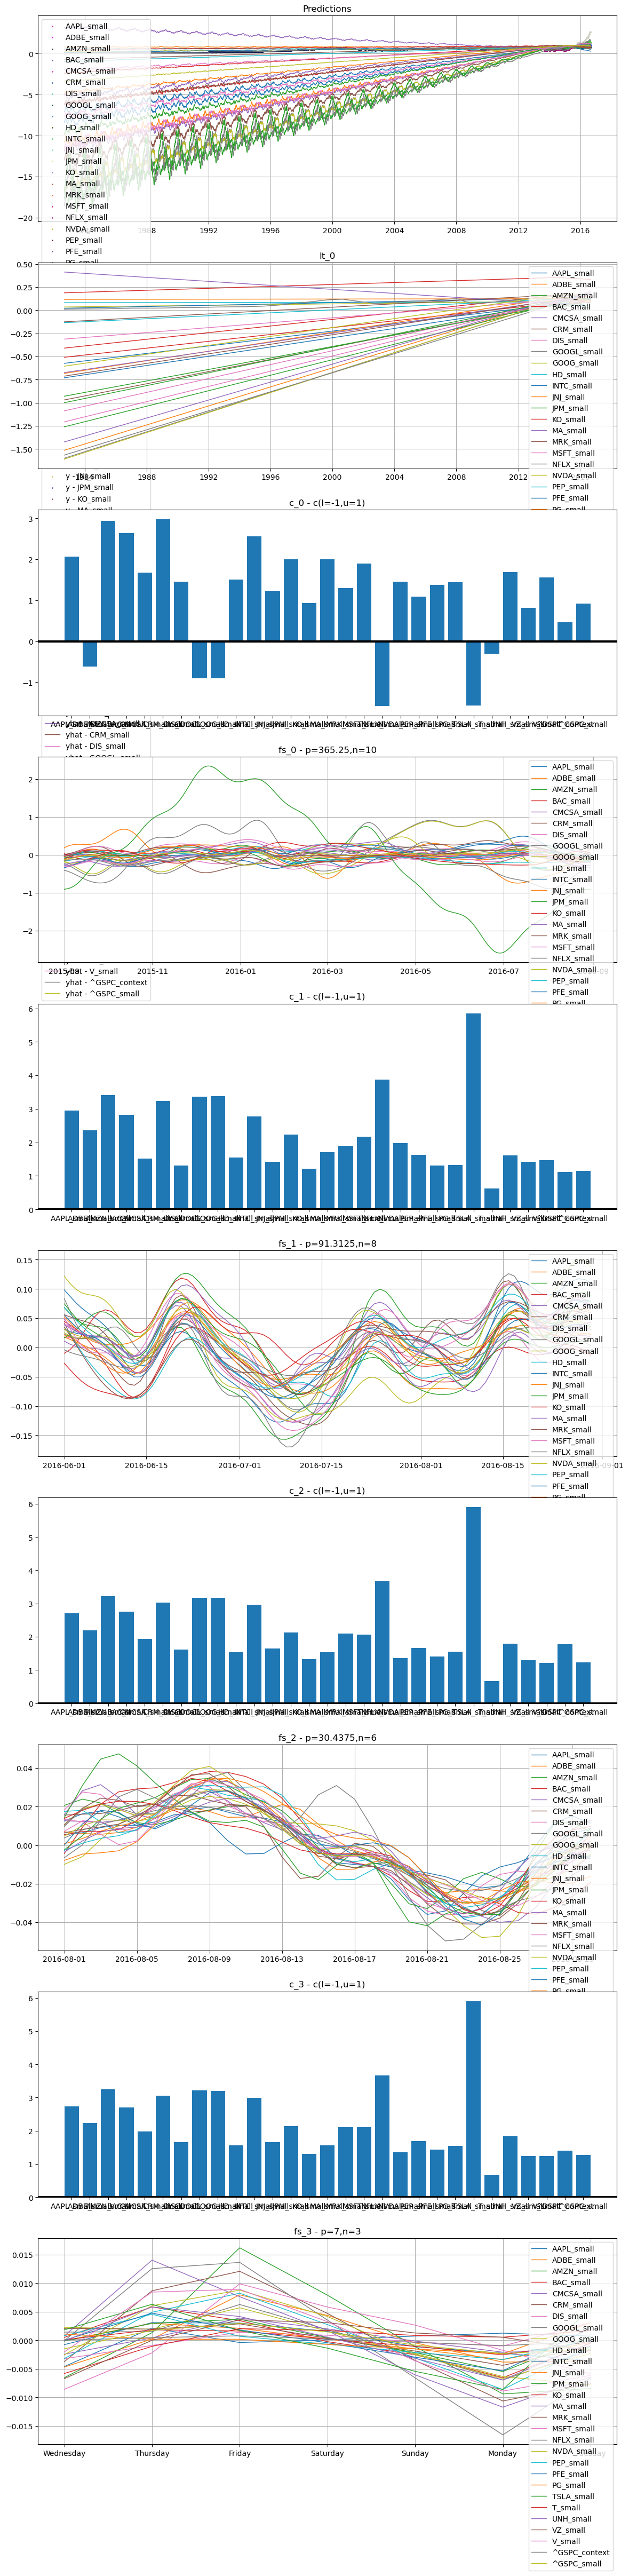

In [14]:
model.plot(yhat, test_df, pool_cols="series")

In [12]:
metrics

,mse,rmse,mae,mape
AAPL_small,0.020178,0.142049,0.123277,0.155353
ADBE_small,0.008822,0.093923,0.086035,0.081033
AMZN_small,0.021737,0.147436,0.117015,0.106420
BAC_small,0.097116,0.311634,0.283351,0.367087
CMCSA_small,0.002693,0.051891,0.044490,0.047842
CRM_small,0.012087,0.109942,0.096614,0.098327
DIS_small,0.035010,0.187110,0.161414,0.198982
GOOGL_small,0.006400,0.080002,0.066191,0.062737
GOOG_small,0.003955,0.062890,0.054506,0.050370
HD_small,0.011878,0.108988,0.094640,0.091472


In [89]:
prophet_metrics["mape"].mean()

0.1944547634231465

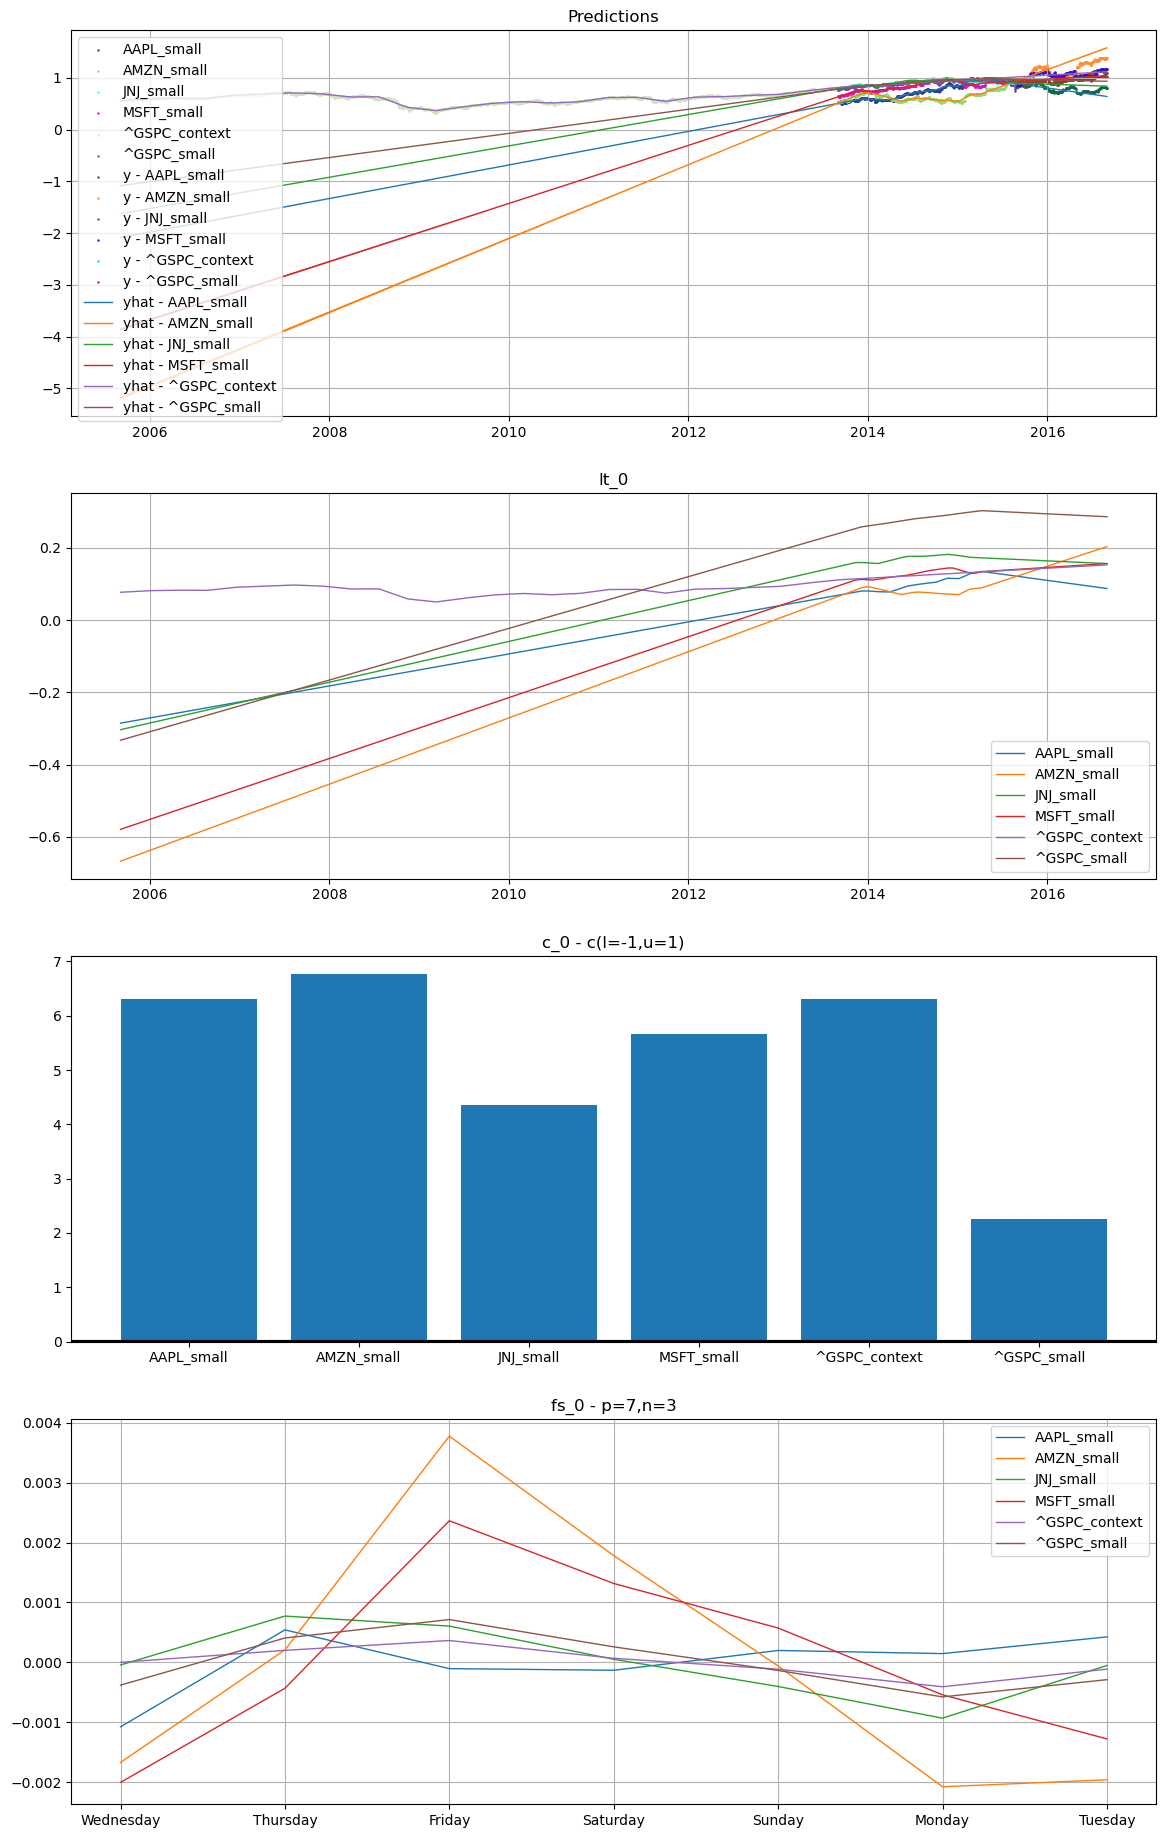

In [73]:
model.plot(yhat, test_df, "series")

In [337]:
print(model.left)
print(model.right)
new_model = pm.Model()
print(model.definition(new_model, model.data, {}, {}))
model.model

MUL
Mul.0


               lt_0 - slope ~ Normal(0, 5)
               lt_0 - delta ~ Laplace(0, 0.05)
           lt_0 - intercept ~ Normal(0, 5)
    fs_0 - beta_mu(p=7,n=3) ~ Normal(0, 10)
 fs_0 - beta_sigma(p=7,n=3) ~ HalfNormal(0, 0.1)
fs_0 - offset_beta(p=7,n=3) ~ Normal(0, 1)
                      sigma ~ HalfNormal(0, 0.5)
               lt_0 - slope ~ Normal(0, 5)
               lt_0 - trend ~ Deterministic(f(lt_0 - intercept, lt_0 - slope, lt_0 - delta))
       fs_0 - beta(p=7,n=3) ~ Deterministic(f(fs_0 - offset_beta(p=7,n=3), fs_0 - beta_mu(p=7,n=3), fs_0 - beta_sigma(p=7,n=3)))
                        obs ~ Normal(f(lt_0 - intercept, lt_0 - slope, fs_0 - offset_beta(p=7,n=3), fs_0 - beta_mu(p=7,n=3), lt_0 - delta, fs_0 - beta_sigma(p=7,n=3)), sigma)

In [287]:
train_df[train_df["series"] == "MSFT"]

,open,high,low,close,typical_price,volume,ds,series,y
2070,27.172499,27.275001,26.972499,18.920573,27.108750,50557875.0,2005-09-03,MSFT,0.545557
2071,27.134999,27.280001,26.974999,18.917072,27.100000,49068250.0,2005-09-04,MSFT,0.545381
2072,27.097499,27.285001,26.977499,18.913571,27.091250,47578625.0,2005-09-05,MSFT,0.545205
2073,27.059999,27.290001,26.980000,18.910070,27.082500,46089000.0,2005-09-06,MSFT,0.545029
2074,26.940001,27.110001,26.820000,18.805012,26.930000,44656100.0,2005-09-07,MSFT,0.541960
...,...,...,...,...,...,...,...,...,...
5715,43.230000,43.950001,42.930000,38.463596,43.502501,50943200.0,2015-08-27,MSFT,0.875478
5716,43.400002,44.150002,43.389999,38.489887,43.717501,28246700.0,2015-08-28,MSFT,0.879805
5717,43.453335,44.076668,43.293332,38.370145,43.654167,30311700.0,2015-08-29,MSFT,0.878530
5718,43.506668,44.003334,43.196665,38.250403,43.590834,32376700.0,2015-08-30,MSFT,0.877256


In [288]:
test_df[test_df["series"] == "MSFT"].iloc[50:]

,open,high,low,close,typical_price,volume,ds,series,y
5770,47.919998,47.990002,47.110001,41.354950,47.555000,2.514430e+07,2015-10-21,MSFT,0.957034
5771,47.529999,48.950001,47.090000,42.082172,47.900000,5.663710e+07,2015-10-22,MSFT,0.963977
5772,52.299999,54.070000,52.250000,46.322803,52.872499,1.352271e+08,2015-10-23,MSFT,1.064047
5773,52.376666,54.153333,52.333333,46.725836,53.048333,1.116958e+08,2015-10-24,MSFT,1.067586
5774,52.453332,54.236666,52.416667,47.128869,53.224166,8.816457e+07,2015-10-25,MSFT,1.071124
...,...,...,...,...,...,...,...,...,...
6080,58.279999,58.700001,57.689999,52.238186,58.174999,2.097120e+07,2016-08-26,MSFT,1.170759
6081,58.246666,58.666667,57.826665,52.259185,58.198332,1.945320e+07,2016-08-27,MSFT,1.171228
6082,58.213333,58.633333,57.963332,52.280183,58.221666,1.793520e+07,2016-08-28,MSFT,1.171698
6083,58.180000,58.599998,58.099998,52.301182,58.244999,1.641720e+07,2016-08-29,MSFT,1.172167


In [305]:
model.model.basic_RVs


[lt_0 - slope ~ Normal(0, 5),
 lt_0 - delta ~ Laplace(0, 0.05),
 lt_0 - intercept ~ Normal(0, 5),
 c_0 - mu_c(l=-1,u=1) ~ Uniform(-1, 1),
 c_0 - offset_c(l=-1,u=1) ~ Normal(0, 1),
 fs_0 - beta_mu(p=365.25,n=10) ~ Normal(0, 10),
 fs_0 - beta_sigma(p=365.25,n=10) ~ HalfNormal(0, 0.1),
 fs_0 - offset_beta(p=365.25,n=10) ~ Normal(0, 1),
 c_1 - mu_c(l=-1,u=1) ~ Uniform(-1, 1),
 c_1 - offset_c(l=-1,u=1) ~ Normal(0, 1),
 fs_1 - beta_mu(p=7,n=3) ~ Normal(0, 10),
 fs_1 - beta_sigma(p=7,n=3) ~ HalfNormal(0, 0.1),
 fs_1 - offset_beta(p=7,n=3) ~ Normal(0, 1),
 sigma ~ HalfNormal(0, 0.5),
 obs ~ Normal(f(lt_0 - intercept, lt_0 - slope, c_1 - offset_c(l=-1,u=1), c_1 - mu_c(l=-1,u=1), c_0 - offset_c(l=-1,u=1), c_0 - mu_c(l=-1,u=1), lt_0 - delta, fs_1 - offset_beta(p=7,n=3), fs_1 - beta_mu(p=7,n=3), fs_0 - offset_beta(p=365.25,n=10), fs_0 - beta_mu(p=365.25,n=10), fs_1 - beta_sigma(p=7,n=3), fs_0 - beta_sigma(p=365.25,n=10)), sigma)]

In [264]:
series_data.iloc[0]["t"], series_data.iloc[-1]["t"]

(0.8002192381474377, 1.0)

In [292]:
yhat

,ds,t,lt_0_0,lt_0_1,c_0_0,c_0_1,fs_0_0,fs_0_1,c_1_0,c_1_1,fs_1_0,fs_1_1,yhat_0,yhat_1
0,2005-09-03,0.000000,0.570144,-0.650290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.570144,-0.650290
1,2005-09-04,0.000274,0.570323,-0.649797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.570323,-0.649797
2,2005-09-05,0.000548,0.570501,-0.649304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.570501,-0.649304
3,2005-09-06,0.000822,0.570680,-0.648810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.570680,-0.648810
4,2005-09-07,0.001096,0.570859,-0.648317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.570859,-0.648317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4010,2016-08-26,1.098931,1.118021,0.950413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.118021,0.950413
4011,2016-08-27,1.099205,1.118301,0.950346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.118301,0.950346
4012,2016-08-28,1.099479,1.118582,0.950278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.118582,0.950278
4013,2016-08-29,1.099753,1.118862,0.950211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.118862,0.950211


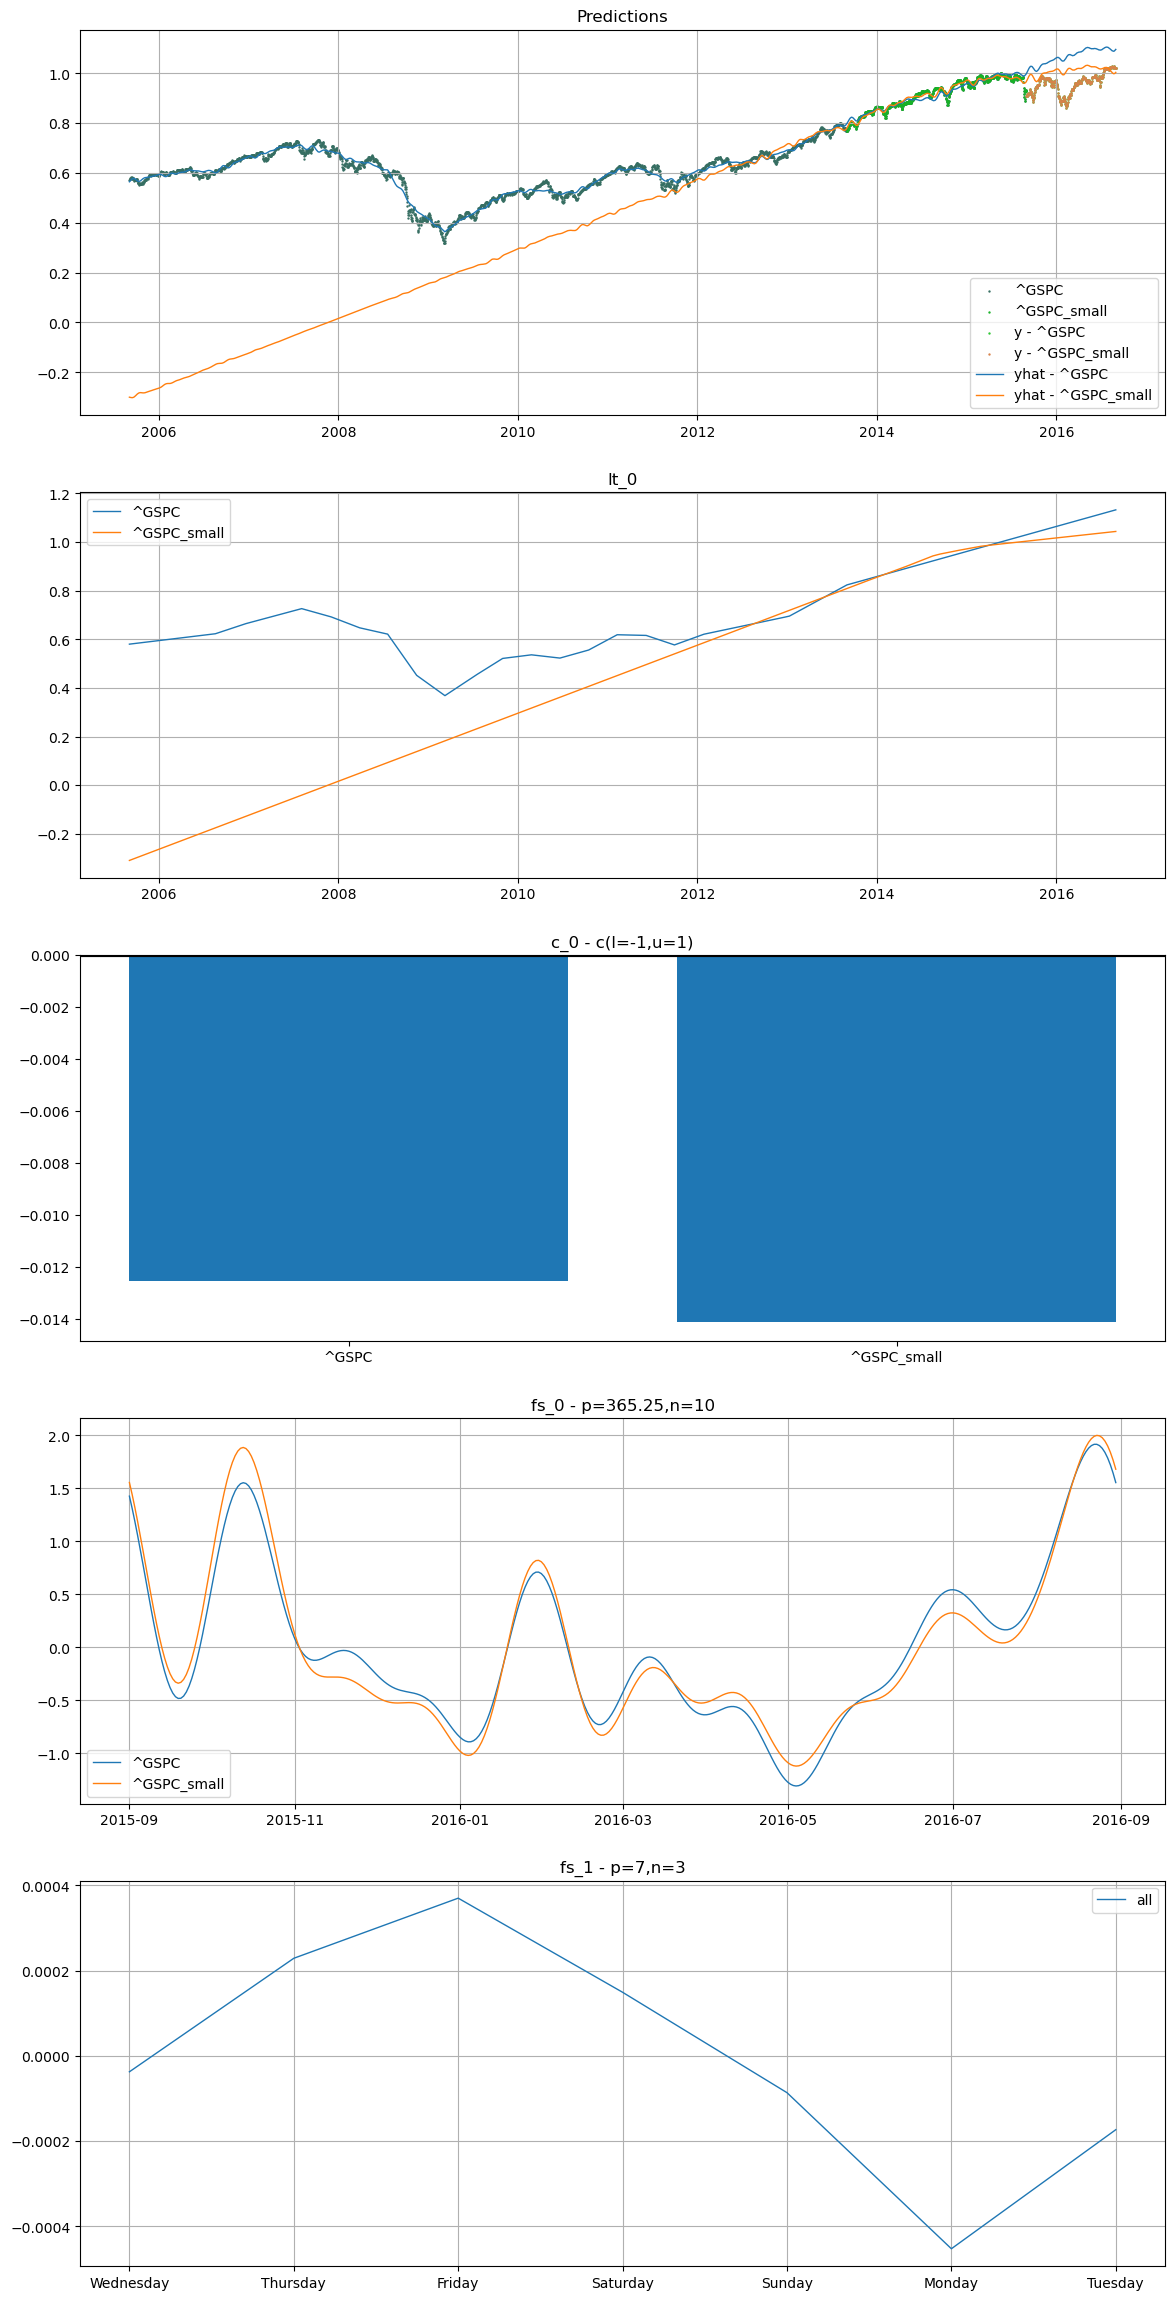

In [31]:
model.plot(yhat, test_df, pool_cols="series")

In [116]:
metrics.head(12)

,mse,rmse,mae,mape
^GSPC,0.139383,0.373341,0.363559,0.512862
^GSPC_small,0.030896,0.175772,0.173489,0.243403
AAPL,0.444225,0.666502,0.646104,0.570239
AAPL_small,0.000540,0.023243,0.019228,0.029503
MSFT,0.135718,0.368399,0.360960,0.481097
MSFT_small,0.000475,0.021791,0.016805,0.021849
AMZN,0.398766,0.631479,0.603658,0.471257
AMZN_small,0.006427,0.080167,0.074704,0.102932
JNJ,0.021299,0.145940,0.139497,0.160631
JNJ_small,0.008237,0.090756,0.089551,0.110744


In [112]:
metrics = []

for df in tqdm(dfs):
    check = generate_train_test_df_financial_crisis(
        window=365 * 9, horizon=365, dfs=[df]
    )
    if check is None:
        continue

    train_df_1, test_df_1, scales_1 = check
    train_df_2, test_df_2, scales_2 = generate_train_test_df_financial_crisis(
        window=365 * 1, horizon=365, dfs=[df]
    )
    train_df_2["series"] += "_small"
    test_df_2["series"] += "_small"
    train_df = pd.concat((train_df_1, train_df_2))
    test_df = pd.concat((test_df_1, test_df_2))

    model = LinearTrend(
        pool_cols="series", pool_type="individual", n_changepoints=25
    ) * (
        Constant(-1, 1, pool_cols="series", pool_type="partial")
        * FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial", shrinkage_strength=1)
        + FourierSeasonality(7, 3, pool_cols="series", pool_type="partial")
    )
    model.fit(train_df, use_prophet_initvals=False, progressbar=False)
    yhat = model.predict(365)
    metrics.append(model.metrics(test_df, yhat, pool_cols="series"))

metrics = pd.concat(metrics)
metrics

100%|██████████| 504/504 [1:22:22<00:00,  9.81s/it]


,mse,rmse,mae,mape
^GSPC,0.139383,0.373341,0.363559,0.512862
^GSPC_small,0.030896,0.175772,0.173489,0.243403
AAPL,0.444225,0.666502,0.646104,0.570239
AAPL_small,0.000540,0.023243,0.019228,0.029503
MSFT,0.135718,0.368399,0.360960,0.481097
...,...,...,...,...
UNM_small,0.004638,0.068103,0.061647,0.095877
SLG,0.271610,0.521162,0.497943,1.461793
SLG_small,0.079292,0.281589,0.248936,0.875930
XRX,0.169622,0.411852,0.392270,0.858567


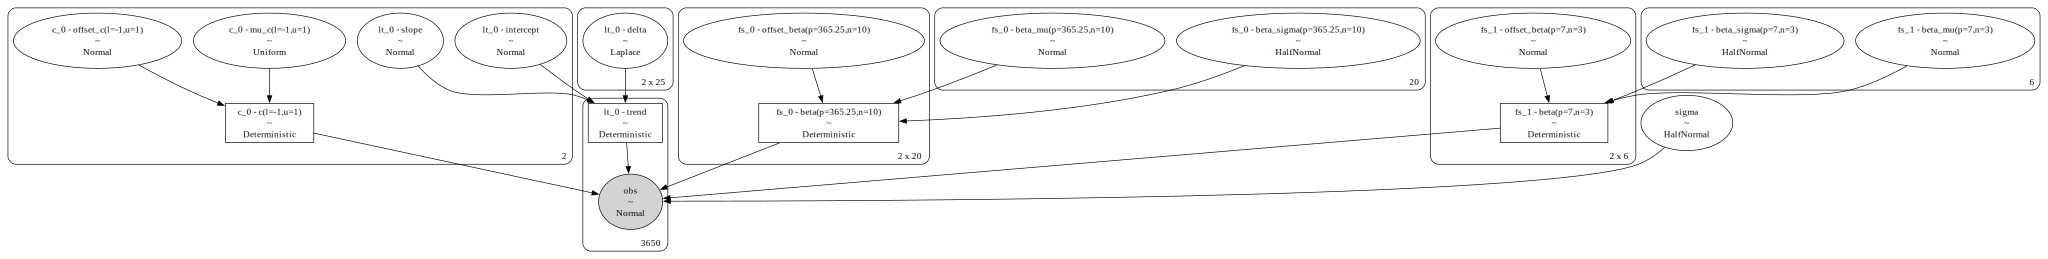

In [70]:
pm.model_to_graphviz(model.model)

### Prophet 3 year all

In [10]:
def get_prophet_metrics(y_trues, y_preds, horizon):
    result = None
    for y_true, y_pred in zip(y_trues, y_preds):
        group_name = y_true["series"].iloc[0]
        single_metrics = {"mse": {}, "rmse": {}, "mae": {}, "mape": {}}
        single_metrics["mse"][group_name] = mean_squared_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        single_metrics["rmse"][group_name] = root_mean_squared_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        single_metrics["mae"][group_name] = mean_absolute_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        single_metrics["mape"][group_name] = mean_absolute_percentage_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        if result is None:
            result = pd.DataFrame(single_metrics)
        else:
            result = pd.concat((result, pd.DataFrame(single_metrics)))

    return result

In [18]:
train_df_prophet, test_df_prophet, scales_prophet = (
    generate_train_test_df_financial_crisis(
        window=365 * 1, horizon=365, dfs=dfs, for_prophet=True
    )
)
train_df_prophet[8].isna().any().any()

False

In [19]:
train_df_prophet[0]

,open,high,low,close,typical_price,volume,ds,series,y
10470,1289.994965,1301.677521,1274.834961,1278.892456,1286.349976,4.409700e+09,2008-09-01,^GSPC,1.000000
10471,1287.829956,1303.040039,1272.199951,1277.579956,1285.162476,4.783560e+09,2008-09-02,^GSPC,0.999077
10472,1276.609985,1280.599976,1265.589966,1274.979980,1274.444977,5.056980e+09,2008-09-03,^GSPC,0.990745
10473,1271.800049,1271.800049,1232.829956,1236.829956,1253.315002,5.212500e+09,2008-09-04,^GSPC,0.974319
10474,1233.209961,1244.939941,1217.229980,1242.310059,1234.422485,5.017080e+09,2008-09-05,^GSPC,0.959632
...,...,...,...,...,...,...,...,...,...
10830,1027.810059,1033.329956,1016.200012,1030.979980,1027.080002,5.785880e+09,2009-08-27,^GSPC,0.798445
10831,1031.619995,1039.469971,1023.130005,1028.930054,1030.787506,5.785780e+09,2009-08-28,^GSPC,0.801327
10832,1029.483317,1034.716634,1020.293335,1026.160034,1027.663330,5.525373e+09,2009-08-29,^GSPC,0.798899
10833,1027.346639,1029.963298,1017.456665,1023.390015,1024.539154,5.264967e+09,2009-08-30,^GSPC,0.796470


In [12]:
test_df_prophet[8].isna().any().any()

False

In [20]:
prophet_forecasts = []

for df, df_test in tqdm(zip(train_df_prophet, test_df_prophet)):
    prophet = Prophet(
        # yearly_seasonality=False,
        # weekly_seasonality=False,
        seasonality_mode="multiplicative",
        # n_changepoints=306,
        # changepoint_range=0.8
    )
    prophet.fit(df)
    future = prophet.make_future_dataframe(periods=365, include_history=True)
    prophet_forecasts.append(prophet.predict(future))

prophet_metrics = get_prophet_metrics(test_df_prophet, prophet_forecasts, 365)
prophet_metrics

412it [01:06,  6.24it/s]


,mse,rmse,mae,mape
^GSPC,0.021052,0.145092,0.108518,0.127334
AAPL,0.036636,0.191406,0.152178,0.112324
MSFT,0.023408,0.152997,0.109697,0.114600
AMZN,0.107695,0.328170,0.295540,0.212840
GOOGL,0.049153,0.221704,0.172790,0.161648
...,...,...,...,...
UNM,0.110725,0.332754,0.286349,0.348130
SLG,0.007104,0.084286,0.063153,0.109992
FTI,0.024365,0.156093,0.121937,0.110545
XRX,0.092323,0.303847,0.266471,0.427663


In [21]:
prophet_metrics["mape"].expanding().mean()

^GSPC    0.127334
AAPL     0.119829
MSFT     0.118086
AMZN     0.141774
GOOGL    0.145749
           ...   
UNM      0.242079
SLG      0.241756
FTI      0.241436
XRX      0.241889
UAA      0.241588
Name: mape, Length: 412, dtype: float64

In [22]:
prophet_metrics["mape"].mean()

0.24158762029849162

### Prophet 9 years all

In [19]:
train_df_prophet, test_df_prophet, scales_prophet = (
    generate_train_test_df_financial_crisis(
        window=365 * 9, horizon=365, dfs=dfs[1:], for_prophet=True
    )
)
train_df_prophet[0]

,open,high,low,close,typical_price,ds,series,y
244,1.106864,1.140625,1.101562,0.948049,1.118234,2000-09-03,AAPL,0.156776
245,1.112863,1.142857,1.106585,0.944283,1.120431,2000-09-04,AAPL,0.157084
246,1.118862,1.145089,1.111607,0.940517,1.122628,2000-09-05,AAPL,0.157392
247,1.095982,1.113839,1.031250,0.880264,1.071149,2000-09-06,AAPL,0.150175
248,1.055804,1.117188,1.040179,0.933927,1.080079,2000-09-07,AAPL,0.151427
...,...,...,...,...,...,...,...,...
3524,6.026786,6.056071,5.886786,5.104968,6.005357,2009-08-27,AAPL,0.841950
3525,6.152500,6.160357,6.018929,5.123043,6.101250,2009-08-28,AAPL,0.855394
3526,6.103571,6.117024,5.994762,5.104565,6.066667,2009-08-29,AAPL,0.850545
3527,6.054643,6.073690,5.970596,5.086087,6.032083,2009-08-30,AAPL,0.845697


In [20]:
test_df_prophet[0]

,open,high,low,close,typical_price,ds,series,y
3529,5.999643,6.071429,5.890714,4.979940,5.966339,2009-09-01,AAPL,0.836479
3530,5.879286,5.986071,5.861071,4.976326,5.906428,2009-09-02,AAPL,0.828080
3531,5.944286,5.967857,5.892857,5.017600,5.938303,2009-09-03,AAPL,0.832549
3532,5.974286,6.096429,5.967500,5.130876,6.030179,2009-09-04,AAPL,0.845430
3533,6.025179,6.118214,6.011339,5.150609,6.065156,2009-09-05,AAPL,0.850334
...,...,...,...,...,...,...,...,...
3889,8.633929,8.664643,8.412857,7.279211,8.585179,2010-08-27,AAPL,1.203640
3890,8.622143,8.702024,8.473809,7.288047,8.609435,2010-08-28,AAPL,1.207041
3891,8.610357,8.739405,8.534761,7.296884,8.633690,2010-08-29,AAPL,1.210441
3892,8.598571,8.776786,8.595714,7.305720,8.657946,2010-08-30,AAPL,1.213842


In [21]:
prophet_forecasts_2 = []

for df, df_test in zip(train_df_prophet, test_df_prophet):
    prophet = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        seasonality_mode="multiplicative",
    )
    prophet.fit(df)
    future = prophet.make_future_dataframe(periods=365, include_history=True)
    prophet_forecasts_2.append(prophet.predict(future))

prophet_metrics_2 = get_prophet_metrics(test_df_prophet, prophet_forecasts, 365)
prophet_metrics_2

AAPL-mape: 0.5716184823964642
MSFT-mape: 0.48252246589876513
AMZN-mape: 0.468101414474341
JNJ-mape: 0.15907303877625711
JPM-mape: 0.390057087619134
PG-mape: 0.27950751813745073
UNH-mape: 0.7159742157302315
DIS-mape: 0.494542825595489
NVDA-mape: 1.2116480227510187
HD-mape: 0.33216263404168855
VZ-mape: 0.2175258472789508
ADBE-mape: 0.4753042883070506
CMCSA-mape: 0.3641038597473838
BAC-mape: 1.5050404686765997
KO-mape: 0.3382585614999315
MRK-mape: 0.6756032323213699
PEP-mape: 0.3458793905339805
T-mape: 0.3683305483676449
PFE-mape: 0.4176848848070181
INTC-mape: 0.49807145747862086
WMT-mape: 0.036340358677011575
ABT-mape: 0.1386193868450951
CSCO-mape: 0.48445019079807194
TMO-mape: 0.4333254787216663
NKE-mape: 0.33272230723087187
XOM-mape: 0.13039772533772115
QCOM-mape: 0.09891232367612118
COST-mape: 0.4004556284286251
CVX-mape: 0.2969148588924672
MCD-mape: 0.12154337858636981
MDT-mape: 0.41145068794338596
NEE-mape: 0.16394270866769883
TXN-mape: 0.5940375442173805
HON-mape: 0.677285712693941